Let us try to create here, through different cells, all the necessary material to run a very first simulation.
We need: user inputs for initial positions; user-given (only for now!) values of 'reward' probability amplitudes; a bunch of operations, a Qiskit extension, and a loop to run the code multiple times. If we are even able to create a visual representation which is updated at each time step, that would be so cool!

(We have to use ESC + M to write a text rather than a coding line in Jupyter).
The following cell shouldn't change across time.

In [1]:
# Some resources on Python robot simulation can be found here: https://jyro.readthedocs.io/en/latest/Jyro%20Simulator.html

In [1]:
from ibm_quantum_widgets import CircuitComposer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute, transpile
import numpy as np
from numpy import pi
from ibm_quantum_widgets import draw_circuit
from qiskit.providers.aer import QasmSimulator
from qiskit.utils import QuantumInstance
from qiskit.visualization import plot_histogram, plot_state_qsphere
from qiskit import *
import random
import matplotlib.pyplot as plt
import pylab
import pandas as pd
from sklearn import preprocessing
import collections
from collections import Counter

In [2]:
# from: https://stackoverflow.com/questions/39298928/play-multiple-sounds-at-the-same-time-in-python

# we can use this to play multiple notes (the chord!) at the same time

from pydub import AudioSegment
from pydub.playback import play

audio0 = AudioSegment.from_file("notes_/example_.wav") # play as an example
# play(audio0)

audio1 = AudioSegment.from_file("notes_/tC.mp3") # note 1 # C played with trumpet (t)
audio2 = AudioSegment.from_file("notes_/fE.mp3") # note 2 # E played with flute (f)
audio3 = AudioSegment.from_file("notes_/cG.mp3") # note 3 # G played with cello (c)

mixed = audio1.overlay(audio2)          # combine , superimpose audio files
mixed1  = mixed.overlay(audio3)          # further combine , superimpose audio files

mixed1.export("notes_/mixed.mp3", format='mp3') # export mixed  audio file
play(mixed1)                             # play mixed audio file
# change this line at each time point, so in the end we can get a little piece :)


Could not import the PyAudio C module '_portaudio'.


Input #0, wav, from '/var/folders/tc/5k6bdv0s421bnc52mnnj7p_w0000gn/T/tmpv16u1376.wav':
  Duration: 00:00:07.31, bitrate: 1411 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, 2 channels, s16, 1411 kb/s


In [3]:
# bounded random walk:
# example from https://stackoverflow.com/questions/46954510/random-walk-series-between-start-end-values-and-within-minimum-maximum-limits


def bounded_random_walk(length, lower_bound,  upper_bound, start, end, std):
    assert (lower_bound <= start and lower_bound <= end)
    assert (start <= upper_bound and end <= upper_bound)

    bounds = upper_bound - lower_bound

    rand = (std * (np.random.random(length) - 0.5)).cumsum()
    rand_trend = np.linspace(rand[0], rand[-1], length)
    rand_deltas = (rand - rand_trend)
    rand_deltas /= np.max([1, (rand_deltas.max()-rand_deltas.min())/bounds])

    trend_line = np.linspace(start, end, length)
    upper_bound_delta = upper_bound - trend_line
    lower_bound_delta = lower_bound - trend_line

    upper_slips_mask = (rand_deltas-upper_bound_delta) >= 0
    upper_deltas =  rand_deltas - upper_bound_delta
    rand_deltas[upper_slips_mask] = (upper_bound_delta - upper_deltas)[upper_slips_mask]

    lower_slips_mask = (lower_bound_delta-rand_deltas) >= 0
    lower_deltas =  lower_bound_delta - rand_deltas
    rand_deltas[lower_slips_mask] = (lower_bound_delta + lower_deltas)[lower_slips_mask]

    return trend_line + rand_deltas

randomData1 = bounded_random_walk(1000, lower_bound=0, upper_bound =100, start=40, end=60, std=10)
randomData2 = bounded_random_walk(1000, lower_bound=0, upper_bound =100, start=40, end=55, std=10)
randomData3 = bounded_random_walk(1000, lower_bound=0, upper_bound =100, start=40, end=62, std=10)

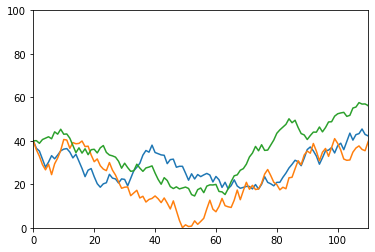

In [4]:
plt.figure()
# plt.plot(range(randomData.shape[0]), randomData1,randomData2,randomData3)
plt.plot(randomData1)
plt.plot(randomData2)
plt.plot(randomData3)
plt.axis([0, 110, 0, 100])
plt.show()
plt.close()

Circuit components initialization. The specific qubits are on $|0\rangle$ by default. They will get a gate later on, according on attributes of classes. The following cell shouldn't change across time.

In [5]:
q = QuantumRegister(5, 'q'); # qubits # changed to 9, formerly 15
m2 = ClassicalRegister(1, 'c1'); # classical bits (separated is better)
m3 = ClassicalRegister(1, 'c2');
m4 = ClassicalRegister(1, 'c3');

qc3 = QuantumCircuit(q, m2, m3, m4); # to reach the target
qc4 = QuantumCircuit(q, m2, m3, m4); # to get back to the nest

In [6]:
class Target:
    def __init__(self,name,x,y): # no indetermination in the target's position
        self.name = name
        self.x = x
        self.y = y

In [7]:
# let us change the reward position
#T = Target("T",0.9,0.5)

# changing the Target position
#T = Target("T",0.2,0.9)
#T = Target("T", 0.9, 0.9)
T = Target("T", 0.9, 0.5)
# for getting back to the beginning
T2 = Target("T2",0.2,0.5)

In [8]:
def reward(T, betax, betay):
    r = round(1 - ((T.x - betax)**2 + (T.y - betay)**2)**0.5, 2)
    # the closer the target, the less the distance, the higher the reward
    return r

Robot $R_1$:$\,\,\,$x-position $|q_0(t)\rangle=\alpha_1^x(t)|0\rangle+\beta_1^x(t)|1\rangle$;$\,\,\,$y-position $|q_1(t)\rangle=\alpha_1^y(t)|0\rangle+\beta_1^y(t)|1\rangle$;$\,\,\,$reward $|q_2(t)\rangle=\gamma_1(t)|0\rangle+\delta_1(t)|1\rangle$.

The class-initialization cells shouldn't change across time. However, cells with numerical values of class attributes should be updated.


In [9]:
class Robot1:
  def __init__(self,name, alphax, betax, alphay, betay, gamma, delta):
    self.name = name
    self.alphax = alphax 
    self.betax = betax 
    self.alphay = alphay 
    self.betay = betay 
    delta = reward(T, betax, betay)
    gamma = round(1 - delta, 2)
    self.gamma = gamma
    self.delta = delta

In [10]:
# manual intervention needed here to avoid circularity
reward(T, 0.2, 0.5) # value of delta

0.3

In [11]:
# manual intervention needed here to avoid circularity
round(1 - reward(T, 0.2, 0.5), 2) # value of gamma

0.7

The following cell, and the other corresponding cells, should be updated by hand at each time:

In [12]:
# (name, alphax, betax, alphay, betay, gamma, delta)
R1 = Robot1("R1",0.8, 0.2, 0.5, 0.5, 0.7, 0.3)

In [13]:
R1.gamma, R1.delta

(0.7, 0.3)

Robot $R_2$:$\,\,\,$x-position $|q_3(t)\rangle=\alpha_2^x(t)|0\rangle+\beta_2^x(t)|1\rangle$;$\,\,\,$y-position $|q_4(t)\rangle=\alpha_2^y(t)|0\rangle+\beta_2^y(t)|1\rangle$;$\,\,\,$reward $|q_5(t)\rangle=\gamma_2(t)|0\rangle+\delta_2(t)|1\rangle$ 

In [14]:
class Robot2:
  def __init__(self,name,alphax, betax, alphay, betay, gamma, delta):
    self.name = name
    self.alphax = alphax 
    self.betax = betax 
    self.alphay = alphay 
    self.betay = betay 
    delta = reward(T, betax, betay)
    gamma = round(1 - delta, 2)
    self.gamma = gamma
    self.delta = delta

In [15]:
reward(T, 0.24, 0.5) # manual intervention needed here to avoid circularity

0.34

In [16]:
round(1 - reward(T, 0.24, 0.5), 2) # manual intervention needed here to avoid circularity

0.66

In [17]:
R2 = Robot2("R2",0.76, 0.24, 0.5, 0.5, 0.66, 0.34) # update by hand this line

In [18]:
R2.delta, R2.gamma, R2.alphax, R2.betax, R2.alphay, R2.betay

(0.34, 0.66, 0.76, 0.24, 0.5, 0.5)

Robot $R_3$:$\,\,\,$x-position $|q_6(t)\rangle=\alpha_3^x(t)|0\rangle+\beta_3^x(t)|1\rangle$;$\,\,\,$y-position $|q_7(t)\rangle=\alpha_3^y(t)|0\rangle+\beta_3^y(t)|1\rangle$;$\,\,\,$reward $|q_8(t)\rangle=\gamma_3(t)|0\rangle+\delta_3(t)|1\rangle$ 

In [19]:
class Robot3:
  def __init__(self, name, alphax, betax, alphay, betay, gamma, delta):
    self.name = name
    self.alphax = alphax 
    self.betax = betax 
    self.alphay = alphay 
    self.betay = betay 
    delta = reward(T, betax, betay)
    gamma = round(1 - delta, 2)
    self.gamma = gamma
    self.delta = delta

In [20]:
reward(T, 0.19, 0.54) # manual intervention needed here to avoid circularity

0.29

In [21]:
round(1 - reward(T, 0.19, 0.54), 2) # manual intervention needed here to avoid circularity

0.71

In [22]:
R3 = Robot3("R3", 0.8, 0.19, 0.46, 0.54, 0.71, 0.29) # to be updated by hand

In [23]:
R3.gamma, R3.delta

(0.71, 0.29)

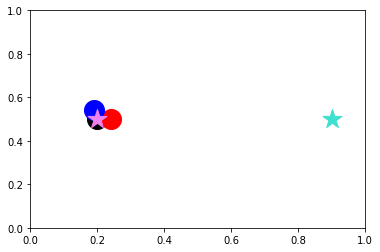

R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet


In [24]:
x = R1.betax
y = R1.betay
#plt.plot(x,y, 'o', c = 'black');
plt.scatter(x,y, s = 400, c = 'black')

x = R2.betax
y = R2.betay
plt.scatter(x, y, s = 400, c = 'red')

x = R3.betax
y = R3.betay
plt.scatter(x, y, s = 400, c = 'blue')

x = T.x
y = T.y
plt.scatter(x, y, s = 400, marker = '*', c = 'turquoise')

x = T2.x
y = T2.y
plt.scatter(x, y, s = 400, marker = '*', c = 'violet')


plt.axis([0, 1, 0, 1])
plt.show() 
print('R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet')

In [25]:
R1.delta, R2.delta, R3.delta

(0.3, 0.34, 0.29)

In [26]:
R3.alphay, R3.betay

(0.46, 0.54)

In [27]:
# Audio section :)

In [28]:

# audio 1, R_1

if (R1.betax == 0):
    if (R1.betay == 0.5):
        audio1 = AudioSegment.from_file("notes_/tC.mp3")
        print("tC")
if (R1.betax > 0 and R1.betax <= 0.17):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tB.mp3")
        print("tB")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tC#.mp3")
        print("tC#")
if (R1.betax > 0.17 and R1.betax <= 0.3):
    if (R1.betay < 0.5): # if (R1.betay >= 0.17 and R1.betay < 0.3):
        audio1 = AudioSegment.from_file("notes_/tA#.mp3")
        print("tA#")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tD.mp3")
        print("tD")
if (R1.betax > 0.3 and R1.betax <= 0.5):
    if (R1.betay < 0.5): # (R1.betay == 1):
        audio1 = AudioSegment.from_file("notes_/tD#.mp3")
        print("tD#")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tA.mp3")
        print("tA")
if (R1.betax > 0.5 and R1.betax <= 0.64):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tE.mp3")
        print("tE")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tG#.mp3")
        print("tG#")
if (R1.betax > 0.64 and R1.betax <= 0.84):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tF.mp3")
        print("tF")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tG.mp3")
        print("tG")
if (R1.betax > 0.84 and R1.betax <= 1):
    #if (R1.betay == 0.5):
    audio1 = AudioSegment.from_file("notes_/tF#.mp3")
    print("tF#")
        
# audio 2, R_2      

if (R2.betax == 0):
    if (R2.betay == 0.5):
        audio2 = AudioSegment.from_file("notes_/fC.mp3")
        print("fC")
if (R2.betax > 0 and R2.betax <= 0.17):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fB.mp3")
        print("fB")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fC#.mp3")
        print("fC#")
if (R2.betax > 0.17 and R2.betax <= 0.3):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fA#.mp3")
        print("fA#")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fD.mp3")
        print("fD")
if (R2.betax > 0.3 and R2.betax <= 0.5):
    if (R2.betay < 0.5): # (R1.betay == 1):
        audio2 = AudioSegment.from_file("notes_/fD#.mp3")
        print("fD#")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fA.mp3")
        print("fA")
if (R2.betax > 0.5 and R2.betax <= 0.64):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fE.mp3")
        print("fE")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fG#.mp3")
        print("fG#")
if (R2.betax > 0.64 and R2.betax <= 0.84):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fF.mp3")
        print("fF")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fG.mp3")
        print("fG")
if (R2.betax > 0.84 and R2.betax <= 1):
    #if (R2.betay == 0.5):
    audio2 = AudioSegment.from_file("notes_/fF#.mp3")
    print("fF#")

        
# audio 3, R_3


if (R3.betax == 0):
    if (R3.betay == 0.5):
        audio3 = AudioSegment.from_file("notes_/cC.mp3")
        print("cC")
if (R3.betax > 0 and R3.betax <= 0.17):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cB.mp3")
        print("cB")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cC#.mp3")
        print("cC#")
if (R3.betax > 0.17 and R3.betax <= 0.3):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cA#.mp3")
        print("cA#")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cD.mp3")
        print("cD")
if (R3.betax > 0.3 and R3.betax <= 0.5):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cD#.mp3")
        print("cD#")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cA.mp3")
        print("cA")
if (R3.betax > 0.5 and R3.betax <= 0.64):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cE.mp3")
        print("cE")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cG#.mp3")
        print("cG#")
if (R3.betax > 0.64 and R3.betax <= 0.84):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cF.mp3")
        print("cF")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cG.mp3")
        print("cG")
if (R3.betax > 0.84 and R3.betax <= 1):
    #if (R3.betay == 0.5):
    audio3 = AudioSegment.from_file("notes_/cF#.mp3")
    print("cF#")

tD
fD
cD


In [29]:
mixed_time1_ = audio1.overlay(audio2)          # combine , superimpose audio files
mixed_time1  = mixed_time1_.overlay(audio3)          # further combine , superimpose audio files

mixed_time1.export("notes_/mixed_time1.mp3", format='mp3') # export mixed  audio file
play(mixed_time1)                             # play mixed audio file
# change this line at each time point, so in the end we can get a little piece :)


Could not import the PyAudio C module '_portaudio'.


Input #0, wav, from '/var/folders/tc/5k6bdv0s421bnc52mnnj7p_w0000gn/T/tmpn2n6qx3q.wav':
  Duration: 00:00:07.34, bitrate: 1411 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, 2 channels, s16, 1411 kb/s


In [30]:
# NEW! ---> January 13, 2022

NEW LINES of code: if the initial reward is high for all the three robots, but not 0.99 yet: --> randomly shuffle one of the positions.

In [31]:
if (R1.delta and R2.delta and R3.delta) >= 0.8 and (R1.delta and R2.delta and R3.delta) < 0.99:
    print("ciao ciao")
    R1.alphax = round(np.random.uniform(0,0.2), 3) # slightly shuffle position of R1
    R1.betax = round(1 - R1.alphax, 3)
    #R1.alphay = round(np.random.uniform(0,0.2), 3) # slightly shuffle position of R1
    #R1.betay = round(1 - R1.alphay, 3)
    print("the new x-positions for R1 are: ", R1.alphax, R1.betax)

In [32]:
R1.alphax, R1.betax, R1.alphay, R1.betay

(0.8, 0.2, 0.5, 0.5)

In [33]:
R1.delta = reward(T, R1.betax, R1.betay)
print(R1.delta)

R2.delta = reward(T, R2.betax, R2.betay)
print(R2.delta)

R3.delta = reward(T, R3.betax, R3.betay)
print(R3.delta)

0.3
0.34
0.29


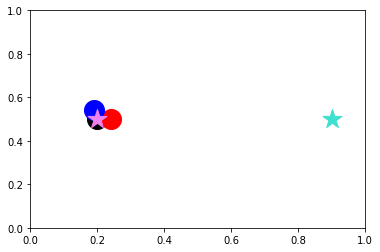

R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet


In [34]:
x = R1.betax
y = R1.betay
#plt.plot(x,y, 'o', c = 'black');
plt.scatter(x,y, s = 400, c = 'black')

x = R2.betax
y = R2.betay
plt.scatter(x, y, s = 400, c = 'red')

x = R3.betax
y = R3.betay
plt.scatter(x, y, s = 400, c = 'blue')

x = T.x
y = T.y
plt.scatter(x, y, s = 400, marker = '*', c = 'turquoise')

x = T2.x
y = T2.y
plt.scatter(x, y, s = 400, marker = '*', c = 'violet')


plt.axis([0, 1, 0, 1])
plt.show() 
print('R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet')

Rewards: here, they are an attribute of each class. This information should be provided by robots themselves according to their observations.

First check: if robots' positions are too far from the target, that is, initial positions
    guarantee a reward lower than a given threshold for all robots, then we have to change
    position. We can accomplish this by randomly moving robots (as in an exploration task),
    and evaluating again their rewards.

In [35]:
# threshold for initial reward
# random fluctuations

if (R1.delta <= 0.4) and (R2.delta <= 0.4) and (R3.delta <= 0.4):
    print("SOS")
    # R1
    R1.alphax = round(np.random.uniform(0,0.9), 3)
    R1.betax = round(1 - R1.alphax, 3)
    print("the new x-positions for R1 are: ", R1.alphax, R1.betax)
    R1.alphay = round(np.random.uniform(0,0.9), 3)
    R1.betay = round(1 - R1.alphay, 3)
    print("the new y-positions for R1 are: ", R1.alphay, R1.betay)
    # R2
    R2.alphax = round(np.random.uniform(0,0.9), 3)
    R2.betax = round(1 - R2.alphax, 3)
    print("the new x-positions for R2 are: ", R2.alphax, R1.betax)
    R2.alphay = round(np.random.uniform(0,0.9), 3)
    R2.betay = round(1 - R2.alphay, 3)
    print("the new y-positions for R2 are: ", R2.alphay, R1.betay)
    # R3
    R3.alphax = round(np.random.uniform(0,0.9), 3)
    R3.betax = round(1 - R3.alphax, 3)
    print("the new x-positions for R3 are: ", R3.alphax, R1.betax)
    R3.alphay = round(np.random.uniform(0,0.9), 3)
    R3.betay = round(1 - R3.alphay, 3)
    print("the new y-positions for R3 are: ", R3.alphay, R1.betay)
    
R1.delta = reward(T, R1.betax, R1.betay)
R1.gamma = 1 - R1.delta
R2.delta = reward(T, R2.betax, R2.betay)
R2.gamma = 1 - R2.delta
R3.delta = reward(T, R3.betax, R3.betay)
R3.gamma = 1 - R3.delta
print(R1.delta, R2.delta, R3.delta)

SOS
the new x-positions for R1 are:  0.28 0.72
the new y-positions for R1 are:  0.066 0.934
the new x-positions for R2 are:  0.145 0.72
the new y-positions for R2 are:  0.343 0.934
the new x-positions for R3 are:  0.377 0.72
the new y-positions for R3 are:  0.391 0.934
0.53 0.84 0.7


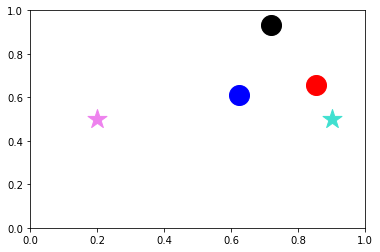

R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet


In [36]:
x = R1.betax
y = R1.betay
#plt.plot(x,y, 'o', c = 'black');
plt.scatter(x,y, s = 400, c = 'black')

x = R2.betax
y = R2.betay
plt.scatter(x, y, s = 400, c = 'red')

x = R3.betax
y = R3.betay
plt.scatter(x, y, s = 400, c = 'blue')

x = T.x
y = T.y
plt.scatter(x, y, s = 400, marker = '*', c = 'turquoise')

x = T2.x
y = T2.y
plt.scatter(x, y, s = 400, marker = '*', c = 'violet')


plt.axis([0, 1, 0, 1])
plt.show() 
print('R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet')

In [37]:

# audio 1, R_1

if (R1.betax == 0):
    if (R1.betay == 0.5):
        audio1 = AudioSegment.from_file("notes_/tC.mp3")
        print("tC")
if (R1.betax > 0 and R1.betax <= 0.17):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tB.mp3")
        print("tB")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tC#.mp3")
        print("tC#")
if (R1.betax > 0.17 and R1.betax <= 0.3):
    if (R1.betay < 0.5): # if (R1.betay >= 0.17 and R1.betay < 0.3):
        audio1 = AudioSegment.from_file("notes_/tA#.mp3")
        print("tA#")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tD.mp3")
        print("tD")
if (R1.betax > 0.3 and R1.betax <= 0.5):
    if (R1.betay < 0.5): # (R1.betay == 1):
        audio1 = AudioSegment.from_file("notes_/tD#.mp3")
        print("tD#")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tA.mp3")
        print("tA")
if (R1.betax > 0.5 and R1.betax <= 0.64):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tE.mp3")
        print("tE")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tG#.mp3")
        print("tG#")
if (R1.betax > 0.64 and R1.betax <= 0.84):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tF.mp3")
        print("tF")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tG.mp3")
        print("tG")
if (R1.betax > 0.84 and R1.betax <= 1):
    #if (R1.betay == 0.5):
    audio1 = AudioSegment.from_file("notes_/tF#.mp3")
    print("tF#")
        
# audio 2, R_2      

if (R2.betax == 0):
    if (R2.betay == 0.5):
        audio2 = AudioSegment.from_file("notes_/fC.mp3")
        print("fC")
if (R2.betax > 0 and R2.betax <= 0.17):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fB.mp3")
        print("fB")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fC#.mp3")
        print("fC#")
if (R2.betax > 0.17 and R2.betax <= 0.3):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fA#.mp3")
        print("fA#")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fD.mp3")
        print("fD")
if (R2.betax > 0.3 and R2.betax <= 0.5):
    if (R2.betay < 0.5): # (R1.betay == 1):
        audio2 = AudioSegment.from_file("notes_/fD#.mp3")
        print("fD#")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fA.mp3")
        print("fA")
if (R2.betax > 0.5 and R2.betax <= 0.64):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fE.mp3")
        print("fE")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fG#.mp3")
        print("fG#")
if (R2.betax > 0.64 and R2.betax <= 0.84):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fF.mp3")
        print("fF")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fG.mp3")
        print("fG")
if (R2.betax > 0.84 and R2.betax <= 1):
    #if (R2.betay == 0.5):
    audio2 = AudioSegment.from_file("notes_/fF#.mp3")
    print("fF#")

        
# audio 3, R_3


if (R3.betax == 0):
    if (R3.betay == 0.5):
        audio3 = AudioSegment.from_file("notes_/cC.mp3")
        print("cC")
if (R3.betax > 0 and R3.betax <= 0.17):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cB.mp3")
        print("cB")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cC#.mp3")
        print("cC#")
if (R3.betax > 0.17 and R3.betax <= 0.3):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cA#.mp3")
        print("cA#")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cD.mp3")
        print("cD")
if (R3.betax > 0.3 and R3.betax <= 0.5):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cD#.mp3")
        print("cD#")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cA.mp3")
        print("cA")
if (R3.betax > 0.5 and R3.betax <= 0.64):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cE.mp3")
        print("cE")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cG#.mp3")
        print("cG#")
if (R3.betax > 0.64 and R3.betax <= 0.84):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cF.mp3")
        print("cF")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cG.mp3")
        print("cG")
if (R3.betax > 0.84 and R3.betax <= 1):
    #if (R3.betay == 0.5):
    audio3 = AudioSegment.from_file("notes_/cF#.mp3")
    print("cF#")

mixed_time2_ = audio1.overlay(audio2)          # combine , superimpose audio files
mixed_time2  = mixed_time2_.overlay(audio3)          # further combine , superimpose audio files

mixed_time2.export("notes_/mixed_time2.mp3", format='mp3') # export mixed  audio file
play(mixed_time2)                             # play mixed audio file
# change this line at each time point, so in the end we can get a little piece :)


tG
fF#
cG#
Could not import the PyAudio C module '_portaudio'.


Input #0, wav, from '/var/folders/tc/5k6bdv0s421bnc52mnnj7p_w0000gn/T/tmp3nbpr5qo.wav':
  Duration: 00:00:07.34, bitrate: 1411 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, 2 channels, s16, 1411 kb/s


In [38]:
# January 22, 2022

I'm adding a check here as well.

NEW LINES of code: IF the initial reward is very high (greater than 0.8) for at least one of the three robots ("or"), THEN the other robots have to just reach it (with a pretty small fluctuation), without entering the circuit.

In [39]:
if((R1.delta >= 0.8) or (R2.delta >= 0.8) or (R3.delta >= 0.8)):
    print('yuk')
    if (R1.delta > R2.delta and R1.delta > R3.delta):
        print('quokka')
        R2.betax = round(R1.betax + np.random.uniform(0,0.1), 3) # Here and later: 0.2. Change of January 23. Re-set as 0.1 on January 24
        R2.alphax = round(1 - R2.betax, 3)
        R2.betay = round(R1.betay + np.random.uniform(0,0.1), 3)
        R2.alphay = round(1 - R2.betay, 3)
        R3.betax = round(R1.betax + np.random.uniform(0,0.1), 3)
        R3.alphax = round(1 - R2.betax, 3)
        R3.betay = round(R1.betay + np.random.uniform(0,0.1), 3)
        R3.alphay = round(1 - R2.betay, 3)
    if (R2.delta > R1.delta and R2.delta > R3.delta):
        print('quagga')
        R1.betax = round(R2.betax + np.random.uniform(0,0.1), 3)
        R1.alphax = round(1 - R1.betax, 3)
        R1.betay = round(R2.betay + np.random.uniform(0,0.1), 3)
        R1.alphay = round(1 - R1.betay, 3)
        R3.betax = round(R2.betax + np.random.uniform(0,0.1), 3)
        R3.alphax = round(1 - R3.betax, 3)
        R3.betay = round(R2.betay + np.random.uniform(0,0.1), 3)
        R3.alphay = round(1 - R3.betay, 3)
    if (R3.delta > R1.delta and R3.delta > R2.delta):
        print('quark')
        R1.betax = round(R3.betax + np.random.uniform(0,0.1), 3)
        R1.alphax = round(1 - R1.betax, 3)
        R1.betay = round(R3.betay + np.random.uniform(0,0.1), 3)
        R1.alphay = round(1 - R1.betay, 3)
        R2.betax = round(R3.betax + np.random.uniform(0,0.1), 3)
        R2.alphax = round(1 - R2.betax, 3)
        R2.betay = round(R3.betay + np.random.uniform(0,0.1), 3)
        R2.alphay = round(1 - R2.betay, 3)
        
R1.delta = reward(T, R1.betax, R1.betay)
print(R1.delta)

R2.delta = reward(T, R2.betax, R2.betay)
print(R2.delta)

R3.delta = reward(T, R3.betax, R3.betay)
print(R2.delta)

yuk
quagga
0.79
0.84
0.84


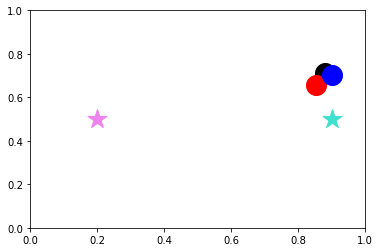

R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet


In [40]:
x = R1.betax
y = R1.betay
#plt.plot(x,y, 'o', c = 'black');
plt.scatter(x,y, s = 400, c = 'black')

x = R2.betax
y = R2.betay
plt.scatter(x, y, s = 400, c = 'red')

x = R3.betax
y = R3.betay
plt.scatter(x, y, s = 400, c = 'blue')

x = T.x
y = T.y
plt.scatter(x, y, s = 400, marker = '*', c = 'turquoise')

x = T2.x
y = T2.y
plt.scatter(x, y, s = 400, marker = '*', c = 'violet')


plt.axis([0, 1, 0, 1])
plt.show() 
print('R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet')

In [41]:

# audio 1, R_1

if (R1.betax == 0):
    if (R1.betay == 0.5):
        audio1 = AudioSegment.from_file("notes_/tC.mp3")
        print("tC")
if (R1.betax > 0 and R1.betax <= 0.17):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tB.mp3")
        print("tB")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tC#.mp3")
        print("tC#")
if (R1.betax > 0.17 and R1.betax <= 0.3):
    if (R1.betay < 0.5): # if (R1.betay >= 0.17 and R1.betay < 0.3):
        audio1 = AudioSegment.from_file("notes_/tA#.mp3")
        print("tA#")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tD.mp3")
        print("tD")
if (R1.betax > 0.3 and R1.betax <= 0.5):
    if (R1.betay < 0.5): # (R1.betay == 1):
        audio1 = AudioSegment.from_file("notes_/tD#.mp3")
        print("tD#")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tA.mp3")
        print("tA")
if (R1.betax > 0.5 and R1.betax <= 0.64):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tE.mp3")
        print("tE")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tG#.mp3")
        print("tG#")
if (R1.betax > 0.64 and R1.betax <= 0.84):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tF.mp3")
        print("tF")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tG.mp3")
        print("tG")
if (R1.betax > 0.84 and R1.betax <= 1):
    #if (R1.betay == 0.5):
    audio1 = AudioSegment.from_file("notes_/tF#.mp3")
    print("tF#")
        
# audio 2, R_2      

if (R2.betax == 0):
    if (R2.betay == 0.5):
        audio2 = AudioSegment.from_file("notes_/fC.mp3")
        print("fC")
if (R2.betax > 0 and R2.betax <= 0.17):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fB.mp3")
        print("fB")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fC#.mp3")
        print("fC#")
if (R2.betax > 0.17 and R2.betax <= 0.3):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fA#.mp3")
        print("fA#")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fD.mp3")
        print("fD")
if (R2.betax > 0.3 and R2.betax <= 0.5):
    if (R2.betay < 0.5): # (R1.betay == 1):
        audio2 = AudioSegment.from_file("notes_/fD#.mp3")
        print("fD#")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fA.mp3")
        print("fA")
if (R2.betax > 0.5 and R2.betax <= 0.64):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fE.mp3")
        print("fE")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fG#.mp3")
        print("fG#")
if (R2.betax > 0.64 and R2.betax <= 0.84):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fF.mp3")
        print("fF")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fG.mp3")
        print("fG")
if (R2.betax > 0.84 and R2.betax <= 1):
    #if (R2.betay == 0.5):
    audio2 = AudioSegment.from_file("notes_/fF#.mp3")
    print("fF#")

        
# audio 3, R_3


if (R3.betax == 0):
    if (R3.betay == 0.5):
        audio3 = AudioSegment.from_file("notes_/cC.mp3")
        print("cC")
if (R3.betax > 0 and R3.betax <= 0.17):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cB.mp3")
        print("cB")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cC#.mp3")
        print("cC#")
if (R3.betax > 0.17 and R3.betax <= 0.3):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cA#.mp3")
        print("cA#")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cD.mp3")
        print("cD")
if (R3.betax > 0.3 and R3.betax <= 0.5):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cD#.mp3")
        print("cD#")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cA.mp3")
        print("cA")
if (R3.betax > 0.5 and R3.betax <= 0.64):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cE.mp3")
        print("cE")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cG#.mp3")
        print("cG#")
if (R3.betax > 0.64 and R3.betax <= 0.84):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cF.mp3")
        print("cF")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cG.mp3")
        print("cG")
if (R3.betax > 0.84 and R3.betax <= 1):
    #if (R3.betay == 0.5):
    audio3 = AudioSegment.from_file("notes_/cF#.mp3")
    print("cF#")

mixed_time3_ = audio1.overlay(audio2)          # combine , superimpose audio files
mixed_time3  = mixed_time3_.overlay(audio3)          # further combine , superimpose audio files

mixed_time3.export("notes_/mixed_time3.mp3", format='mp3') # export mixed  audio file
play(mixed_time3) 


tF#
fF#
cF#
Could not import the PyAudio C module '_portaudio'.


Input #0, wav, from '/var/folders/tc/5k6bdv0s421bnc52mnnj7p_w0000gn/T/tmpa0kescw9.wav':
  Duration: 00:00:07.34, bitrate: 1411 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, 2 channels, s16, 1411 kb/s


In [42]:
# Another round of SOS re-shuffle

# threshold for initial reward
# random fluctuations

if (R1.delta <= 0.4) and (R2.delta <= 0.4) and (R3.delta <= 0.4):
    print("SOS")
    # R1
    R1.alphax = round(np.random.uniform(0,0.9), 3)
    R1.betax = round(1 - R1.alphax, 3)
    print("the new x-positions for R1 are: ", R1.alphax, R1.betax)
    R1.alphay = round(np.random.uniform(0,0.9), 3)
    R1.betay = round(1 - R1.alphay, 3)
    print("the new y-positions for R1 are: ", R1.alphay, R1.betay)
    # R2
    R2.alphax = round(np.random.uniform(0,0.9), 3)
    R2.betax = round(1 - R2.alphax, 3)
    print("the new x-positions for R2 are: ", R2.alphax, R1.betax)
    R2.alphay = round(np.random.uniform(0,0.9), 3)
    R2.betay = round(1 - R2.alphay, 3)
    print("the new y-positions for R2 are: ", R2.alphay, R1.betay)
    # R3
    R3.alphax = round(np.random.uniform(0,0.9), 3)
    R3.betax = round(1 - R3.alphax, 3)
    print("the new x-positions for R3 are: ", R3.alphax, R1.betax)
    R3.alphay = round(np.random.uniform(0,0.9), 3)
    R3.betay = round(1 - R3.alphay, 3)
    print("the new y-positions for R3 are: ", R3.alphay, R1.betay)
    
R1.delta = reward(T, R1.betax, R1.betay)
R1.gamma = 1 - R1.delta
R2.delta = reward(T, R2.betax, R2.betay)
R2.gamma = 1 - R2.delta
R3.delta = reward(T, R3.betax, R3.betay)
R3.gamma = 1 - R3.delta
print(R1.delta, R2.delta, R3.delta)

0.79 0.84 0.8


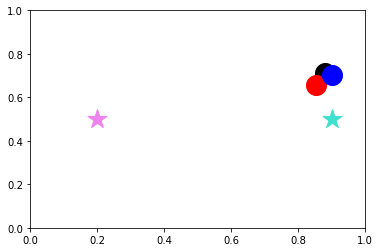

R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet


In [43]:
x = R1.betax
y = R1.betay
#plt.plot(x,y, 'o', c = 'black');
plt.scatter(x,y, s = 400, c = 'black')

x = R2.betax
y = R2.betay
plt.scatter(x, y, s = 400, c = 'red')

x = R3.betax
y = R3.betay
plt.scatter(x, y, s = 400, c = 'blue')

x = T.x
y = T.y
plt.scatter(x, y, s = 400, marker = '*', c = 'turquoise')

x = T2.x
y = T2.y
plt.scatter(x, y, s = 400, marker = '*', c = 'violet')


plt.axis([0, 1, 0, 1])
plt.show() 
print('R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet')

In [44]:

# audio 1, R_1

if (R1.betax == 0):
    if (R1.betay == 0.5):
        audio1 = AudioSegment.from_file("notes_/tC.mp3")
        print("tC")
if (R1.betax > 0 and R1.betax <= 0.17):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tB.mp3")
        print("tB")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tC#.mp3")
        print("tC#")
if (R1.betax > 0.17 and R1.betax <= 0.3):
    if (R1.betay < 0.5): # if (R1.betay >= 0.17 and R1.betay < 0.3):
        audio1 = AudioSegment.from_file("notes_/tA#.mp3")
        print("tA#")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tD.mp3")
        print("tD")
if (R1.betax > 0.3 and R1.betax <= 0.5):
    if (R1.betay < 0.5): # (R1.betay == 1):
        audio1 = AudioSegment.from_file("notes_/tD#.mp3")
        print("tD#")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tA.mp3")
        print("tA")
if (R1.betax > 0.5 and R1.betax <= 0.64):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tE.mp3")
        print("tE")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tG#.mp3")
        print("tG#")
if (R1.betax > 0.64 and R1.betax <= 0.84):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tF.mp3")
        print("tF")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tG.mp3")
        print("tG")
if (R1.betax > 0.84 and R1.betax <= 1):
    #if (R1.betay == 0.5):
    audio1 = AudioSegment.from_file("notes_/tF#.mp3")
    print("tF#")
        
# audio 2, R_2      

if (R2.betax == 0):
    if (R2.betay == 0.5):
        audio2 = AudioSegment.from_file("notes_/fC.mp3")
        print("fC")
if (R2.betax > 0 and R2.betax <= 0.17):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fB.mp3")
        print("fB")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fC#.mp3")
        print("fC#")
if (R2.betax > 0.17 and R2.betax <= 0.3):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fA#.mp3")
        print("fA#")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fD.mp3")
        print("fD")
if (R2.betax > 0.3 and R2.betax <= 0.5):
    if (R2.betay < 0.5): # (R1.betay == 1):
        audio2 = AudioSegment.from_file("notes_/fD#.mp3")
        print("fD#")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fA.mp3")
        print("fA")
if (R2.betax > 0.5 and R2.betax <= 0.64):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fE.mp3")
        print("fE")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fG#.mp3")
        print("fG#")
if (R2.betax > 0.64 and R2.betax <= 0.84):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fF.mp3")
        print("fF")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fG.mp3")
        print("fG")
if (R2.betax > 0.84 and R2.betax <= 1):
    #if (R2.betay == 0.5):
    audio2 = AudioSegment.from_file("notes_/fF#.mp3")
    print("fF#")

        
# audio 3, R_3


if (R3.betax == 0):
    if (R3.betay == 0.5):
        audio3 = AudioSegment.from_file("notes_/cC.mp3")
        print("cC")
if (R3.betax > 0 and R3.betax <= 0.17):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cB.mp3")
        print("cB")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cC#.mp3")
        print("cC#")
if (R3.betax > 0.17 and R3.betax <= 0.3):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cA#.mp3")
        print("cA#")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cD.mp3")
        print("cD")
if (R3.betax > 0.3 and R3.betax <= 0.5):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cD#.mp3")
        print("cD#")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cA.mp3")
        print("cA")
if (R3.betax > 0.5 and R3.betax <= 0.64):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cE.mp3")
        print("cE")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cG#.mp3")
        print("cG#")
if (R3.betax > 0.64 and R3.betax <= 0.84):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cF.mp3")
        print("cF")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cG.mp3")
        print("cG")
if (R3.betax > 0.84 and R3.betax <= 1):
    #if (R3.betay == 0.5):
    audio3 = AudioSegment.from_file("notes_/cF#.mp3")
    print("cF#")

mixed_time4_ = audio1.overlay(audio2)          # combine , superimpose audio files
mixed_time4  = mixed_time4_.overlay(audio3)          # further combine , superimpose audio files

mixed_time4.export("notes_/mixed_time4.mp3", format='mp3') # export mixed  audio file
play(mixed_time4) 

tF#
fF#
cF#
Could not import the PyAudio C module '_portaudio'.


Input #0, wav, from '/var/folders/tc/5k6bdv0s421bnc52mnnj7p_w0000gn/T/tmpopoii6ms.wav':
  Duration: 00:00:07.34, bitrate: 1411 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, 2 channels, s16, 1411 kb/s


We can now attempt to relate class attributes with quantum states.
This passage should be automatically changed when class attributes change, in the loop! (while).

Let us suppose that $R_1$ received a signal from $R_2,\,R_3$ with the message: ``Where I am, what I found.'' That is: xy-position and reward information. Then, $R_1$ chooses to follow the more successful robot that has the more precise position localization.

Before all of that, we use an if: if $R_2$ already has a high reward, it remains where it is.
If we had the same minimization function for all robots, thus, already at the second step all robots would converge toward the same point. 

Now: initialization of qubits.

If the robot with the highest reward is $R_3$, then $R_1\rightarrow R_3$ and $R_2\rightarrow R_3$ while entering the gate. $q[0],\,q[1],\,q[2]$ takes positions (x and y) and reward of $R_3$ in this case. The output with $q[3],\,q[4]$ ($q[2]$ remains the same) goes to new x, y of $R_1$ and of $R_2$.

GATE HERE!! GATE 1

In [45]:
if (R1.delta > R2.delta) and (R1.delta > R3.delta):
    if (R1.alphax < 0.3): # I have to customize state vectors according to precise probabilities!
        qc3.x(q[0])        # just using the NOT gate as a test
    if (R1.alphax == 0.5): # I have to customize state vectors according to precise probabilities!
        qc3.h(q[0])
    if (R1.alphax >= 0.3) and (R2.alphax < 0.5):
        print('jungle!')
        qc3.ry(1.9106332, q[0])
    if (R1.alphax >= 0.6) and (R2.alphax < 0.7):
        print('ocean!')
        qc3.ry(1.2309594, q[0])
    if (R1.alphay <= 0.2): # else: the qubit sticks with the default value '0'
        qc3.x(q[1])
    if (R1.alphay == 0.5): # I have to customize state vectors according to precise probabilities!
        qc3.h(q[1])
    if (R1.alphay >= 0.3) and (R2.alphay < 0.5):
        print('jungle!')
        qc3.ry(1.9106332, q[1])
    if (R1.alphay >= 0.6) and (R2.alphay < 0.7):
        print('ocean!')
        qc3.ry(1.2309594, q[1])
    if (R1.delta == 0.5):
        qc3.h(q[2])
    if (R1.delta == 0.6):
        qc3.h(q[2])
    if (R1.delta >= 0.7):
        qc3.x(q[2])
    if (R1.gamma >= 0.3) and (R2.gamma < 0.5):
        print('jungle!')
        qc3.ry(1.9106332, q[2])
    if (R1.gamma >= 0.6) and (R2.gamma < 0.7):
        print('ocean!')
        qc3.ry(1.2309594, q[2])
# elif (R1.delta > R2.delta) and (R1.delta > R3.delta): # February 13: NO!!!
elif (R2.delta > R1.delta) and (R2.delta > R3.delta):
    print('dog')
    if (R2.alphax < 0.3): # I have to customize state vectors according to precise probabilities!
        qc3.x(q[0])        # just using the NOT gate as a test
    if (R2.alphax == 0.5): # I have to customize state vectors according to precise probabilities!
        qc3.h(q[0])
    if (R2.alphax >= 0.3) and (R1.alphax < 0.5):
        print('jungle!')
        qc3.ry(1.9106332, q[0])
    if (R2.alphax >= 0.6) and (R1.alphax < 0.7):
        print('ocean!')
        qc3.ry(1.2309594, q[0])
    if (R2.alphay <= 0.2): # else: the qubit sticks with the default value '0'
        qc3.x(q[1])
    if (R2.alphay == 0.5): # I have to customize state vectors according to precise probabilities!
        qc3.h(q[1])
    if (R2.alphay >= 0.3) and (R1.alphay < 0.5):
        print('jungle!')
        qc3.ry(1.9106332, q[1])
    if (R2.alphay >= 0.6) and (R1.alphay < 0.7):
        print('ocean!')
        qc3.ry(1.2309594, q[1])
    if (R2.delta == 0.5):
        qc3.h(q[2])
    if (R2.delta == 0.6):
        qc3.h(q[2])
    if (R2.delta >= 0.7):
        qc3.x(q[2])
    if (R2.gamma >= 0.3) and (R1.gamma < 0.5):
        print('jungle!')
        qc3.ry(1.9106332, q[2])
    if (R2.gamma >= 0.6) and (R1.gamma < 0.7):
        print('ocean!')
        qc3.ry(1.2309594, q[2])
else:
    print('cat') # I made some tests to check the IF conditions
    if (R3.alphax < 0.3): 
        qc3.x(q[0])
    if (R3.alphax == 0.5):
        qc3.h(q[0])
    if (R3.alphax >= 0.3) and (R3.alphax < 0.5):
        print('jungle!')
        qc3.ry(1.9106332, q[0])
    if (R3.alphax >= 0.6) and (R3.alphax < 0.7):
        print('ocean!')
        qc3.ry(1.2309594, q[0])
    if (R3.alphay < 0.3):
        qc3.x(q[1])
    if (R3.alphay == 0.5):
        qc3.h(q[1])
    if (R3.alphay >= 0.3) and (R3.alphay < 0.5):
        print('jungle!')
        qc3.ry(1.9106332, q[1])
    if (R3.alphay >= 0.6) and (R3.alphay < 0.7):
        print('ocean!')
        qc3.ry(1.2309594, q[1])
    if (R3.delta == 0.5):
        qc3.h(q[2])
    if (R3.delta == 0.6):
        qc3.h(q[2])
    if (R3.delta >= 0.7):
        qc3.x(q[2])
    if (R3.gamma >= 0.3) and (R3.gamma < 0.5):
        print('jungle!')
        qc3.ry(1.9106332, q[2])
    if (R3.gamma >= 0.6) and (R3.gamma < 0.7):
        print('ocean!')
        qc3.ry(1.2309594, q[2])

dog
jungle!


Numeration of qubits within IF instructions is slightly different than the initial one. In fact, some distinction across qubits was needed to clearly build the whole circuit later on. Thus, I decided to keep them apart.

CircuitComposer(circuit=<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fbc44794d90>, editable=Fals…

{'0 1 1': 360, '1 1 1': 664}
1 1 1
[]
['1 1 1', '1 1 1', '0 1 1', '1 1 1', '1 1 1', '1 1 1', '0 1 1', '1 1 1', '1 1 1', '1 1 1']


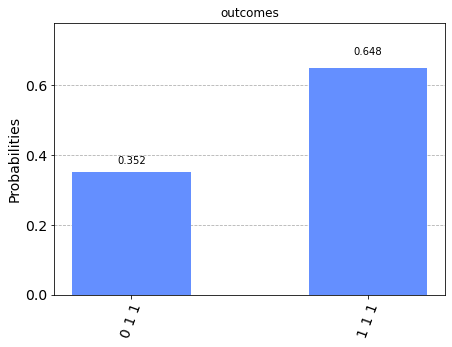

In [46]:
# this is the core code, and it is unchanged across time

qc3.barrier(q)
qc3.ccx(q[0],q[1],q[3])
qc3.ccx(q[0],q[1],q[4])

qc3.reset(q[3]);
qc3.reset(q[4]);

qc3.ccx(q[0],q[2],q[3])
qc3.ccx(q[1],q[2],q[4])

qc3.x(q[2])

qc3.ch(q[2],q[3])
qc3.ch(q[2],q[4])

qc3.x(q[2])

qc3.barrier(q)

# perform measurements and store them in classical bits

qc3.measure(q[2],m2[0])
qc3.measure(q[3],m3[0])
qc3.measure(q[4],m4[0])

# visualization of the ciruit

draw_circuit(qc3)

# definition of quantum simulator

simulator = Aer.get_backend('qasm_simulator') # statevector_simulator # aer_simulator # qasm_simulator
qc3 = transpile(qc3, simulator)
cc = collections.Counter()

# Run and get counts
result = simulator.run(qc3, shots=1024).result()
counts = result.get_counts(qc3)
counts2 = counts.most_frequent() # does not work if multiple states have the same counts
# decide something if multiple states have the same count --> e.g., ``choose the first''
counts3 = cc.most_common(2)
print(counts)
print(counts2)
print(counts3)
result = simulator.run(qc3, shots=10, memory=True).result()
memory = result.get_memory(qc3)
print(memory)
plot_histogram(counts, title='outcomes')
# TAKE the TWO more present outcomes

In [54]:
# keep the two more present outcomes.

In [47]:
print(counts2) # order: R3, R2, R1. Add some uncertainty?
# export as an array
str = counts2
arr1 = str.split(' ') # to split the string and avoid empty spaces as array elements
print(arr1)
weight1 = 664  # AT HAND ONLY FOR NOW

arr2 = ['0','1','1'] # 111 # 011
print(arr2)
weight2 = 360
# BY HAND ONLY FOR NOW


# an attempt, not so good, to automatize this passage:

print(memory)

data = Counter(memory)
data.most_common()   # Returns all unique items and their counts
data.most_common(3) 

print(data.most_common())
print(data.most_common(1))
arrx1 = data.most_common(2)[0]
print(arrx1)
arrx2 = data.most_common(2)[1]
print(arrx2)



1 1 1
['1', '1', '1']
['0', '1', '1']
['1 1 1', '1 1 1', '0 1 1', '1 1 1', '1 1 1', '1 1 1', '0 1 1', '1 1 1', '1 1 1', '1 1 1']
[('1 1 1', 8), ('0 1 1', 2)]
[('1 1 1', 8)]
('1 1 1', 8)
('0 1 1', 2)


In [48]:
# array 1
arr1

['1', '1', '1']

In [49]:
# array 2
arr2

['0', '1', '1']

Let us create a sort of weighted sum.

It not convenient to set up q[3], q[4], because we need coordinates attribution....

Now, we re-calculate the positions of the robots that entered the gate. To this aim, use their reward (which is unchanged yet).

Position for $R_1$:

In [50]:
if (R1.delta > R2.delta) and (R1.delta > R3.delta):
    # if R1 didn't enter the gate, keep its position
    R1.alphax = R1.alphax
    R1.betax = R1.betax
    R1.alphay = R1.alphay
    R1.betay = R1.betay
else:
    # same outcome = 1 # January 23
    # x part
    
    # change of January 38: I'm substituting [0] with [1] and vice versa, because the output is: y, x, reward
    if (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight1 - weight2) > 50 and (weight1 - weight2) < 200): # no ABS here # change of January 23
        print("bla")
        R1.alphax = 0.3   
        R1.betax = 0.7   
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight2 - weight1) > 50 and (weight1 - weight2) < 200): # no ABS here # change of January 23
        print("gulp")
        R1.alphax = 0.7   
        R1.betax = 0.3    
    elif (arr1[1] == arr2[0]) and (arr1[1] == '1') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): # change of January 23
        print("stra-gulp")
        R1.alphax = 0.5 # change temporarily made on January 24: random generator rather than 0.5  
        R1.betax = 0.5 # same as above
    elif (arr1[1] == arr2[0]) and (arr1[1] == '1') and ((weight2 - weight1) > 800): # no abs # change of January 23
        print("thunderstorm!")
        R1.alphax = 0 
        R1.betax = 1
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
        print("avalanche!")
        R1.alphax = 0.1 
        R1.betax = 0.9
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
        print("earthquake!")
        R1.alphax = 0.9
        R1.betax = 0.1
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 23
        print("avalanche bis!")
        R1.alphax = 0.1 # the same also in this case
        R1.betax = 0.9 # the same also in this case
    # same = outcome 0  # January 23
    elif (arr1[1] == arr2[1]) and (arr1[1] == '0') and ((weight1 - weight2) > 50): # no ABS here # change of January 23
        print("bla 2")
        R1.alphax = 0.7  # the opposite??   
        R1.betax = 0.3  # the opposite??   
    elif (arr1[1] == arr2[1]) and (arr1[1] == '0') and ((weight2 - weight1) > 50): # no ABS here # change of January 23
        print("gulp 2")
        R1.alphax = 0.3  # the opposite??   
        R1.betax = 0.7  # the opposite??    
    elif (arr1[1] == arr2[1]) and (arr1[1] == '0') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): # change of January 23
        print("stra-gulp 2")
        R1.alphax = 0.5 # change temporarily made on January 24: random generator rather than 0.5 #1   # the opposite
        R1.betax = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.5 #0  # the opposite 
    # different outcomes
    elif arr1[1] != arr2[1]:  # January 23
        print("blue")
        if (arr1[1] != arr2[1]) and (weight1 == weight2 or np.absolute(weight1 - weight2) < 50):
            print("google 1")
            R1.alphax = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.5
            R1.betax = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.5
        if (arr1[1] == '1' and arr2[1] == '0') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): 
            # include the case of a very small difference!
            print("uffdah")
            R1.alphax = 0.5
            R1.betax = 0.5
        if (arr1[1] == '1' and arr2[1] == '0'):
            if (weight1 - weight2 >= 50 and weight1 - weight2 <= 200):
                print("abc")
                R1.alphax = 0.3
                R1.betax = 0.7
            if (weight2 - weight1 >= 50 and weight1 - weight2 <= 200):
                print("bca")
                R1.alphax = 0.7
                R1.betax = 0.3
            if ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 23
                print("news")
                R1.alphax = 0.2 #
                R1.betax = 0.8 #
            if ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
                print("idea")
                R1.alphax = 0.8 #
                R1.betax = 0.2 #
            if ((weight1 - weight2) > 200 and (weight2 - weight1) >= 800): # no abs # change of January 28
                print("news")
                R1.alphax = 0.1 #
                R1.betax = 0.9 #
            if ((weight2 - weight1) > 200 and (weight2 - weight1) >= 800): # no abs # change of January 28
                print("idea")
                R1.alphax = 0.9 #
                R1.betax = 0.1 #
        if (arr1[1] == '0') and (arr2[1] == '1'):
            if (weight1 - weight2 >= 50 and weight1 - weight2 <= 200):
                print("bac")
                R1.alphax = 0.7
                R1.betax = 0.3
            if (weight2 - weight1 >= 50 and weight1 - weight2 <= 200):
                print("cba")
                R1.alphax = 0.3
                R1.betax = 0.7
            if ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 26
                print("brain")
                R1.alphax = 0.7 # 0.9
                R1.betax = 0.3 # 0.1
            if ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 26
                print("hand")
                R1.alphax = 0.3 # 0.1
                R1.betax = 0.7 # 0.9
            if ((weight1 - weight2) > 200 and (weight2 - weight1) >= 800): # no abs # change of January 26
                print("brain2")
                R1.alphax = 0.9 # 0.9
                R1.betax = 0.1 # 0.1
            if ((weight2 - weight1) > 200 and (weight2 - weight1) >= 800): # no abs # change of January 26
                print("hand2")
                R1.alphax = 0.1 # 0.1
                R1.betax = 0.9 # 0.9
    # y part
    
    # change of January 26
    
    if (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight1 - weight2) > 50 and (weight1 - weight2) < 200): # no ABS here # change of January 23
        print("bla")
        R1.alphay = 0.3   
        R1.betay = 0.7   
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight2 - weight1) > 50 and (weight1 - weight2) < 200): # no ABS here # change of January 23
        print("gulp")
        R1.alphay = 0.7   
        R1.betay = 0.3    
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): # change of January 23
        print("stra-gulp")
        R1.alphay = 0.5 # change temporarily made on January 24: random generator rather than 0.5  
        R1.betay = 0.5 # same as above
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight2 - weight1) > 800): # no abs # change of January 23
        print("thunderstorm!")
        R1.alphay = 0 
        R1.betay = 1
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
        print("avalanche!")
        R1.alphay = 0.1 
        R1.betay = 0.9
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
        print("earthquake!")
        R1.alphay = 0.9
        R1.betay = 0.1
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 23
        print("avalanche bis!")
        R1.alphay = 0.1 # the same also in this case
        R1.betay = 0.9 # the same also in this case
    # same = outcome 0  # January 23
    elif (arr1[0] == arr2[0]) and (arr1[0] == '0') and ((weight1 - weight2) > 50): # no ABS here # change of January 23
        print("bla 2")
        R1.alphay = 0.7  # the opposite??   
        R1.betay = 0.3  # the opposite??   
    elif (arr1[0] == arr2[0]) and (arr1[0] == '0') and ((weight2 - weight1) > 50): # no ABS here # change of January 23
        print("gulp 2")
        R1.alphay = 0.3  # the opposite??   
        R1.betay = 0.7  # the opposite??    
    elif (arr1[0] == arr2[0]) and (arr1[0] == '0') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): # change of January 23
        print("stra-gulp 2")
        R1.alphay = 0.5 # change temporarily made on January 24: random generator rather than 0.5 #1   # the opposite
        R1.betay = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.5 #0  # the opposite 
    # different outcomes
    elif arr1[0] != arr2[0]:  # January 23
        print("blue")
        if (arr1[0] != arr2[0]) and (weight1 == weight2 or np.absolute(weight1 - weight2) < 50):
            print("google 1")
            R1.alphay = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.5
            R1.betay = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.5
        if (arr1[0] == '1' and arr2[0] == '0') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): 
            # include the case of a very small difference!
            print("uffdah")
            R1.alphay = 0.5
            R1.betay = 0.5
        if (arr1[0] == '1' and arr2[0] == '0'):
            if (weight1 - weight2 >= 50 and weight1 - weight2 <= 200):
                print("abc")
                R1.alphay = 0.3
                R1.betay = 0.7
            if (weight2 - weight1 >= 50 and weight1 - weight2 <= 200):
                print("bca")
                R1.alphay = 0.7
                R1.betay = 0.3
            if ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 23
                print("news")
                R1.alphay = 0.2 #
                R1.betay = 0.8 #
            if ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
                print("idea")
                R1.alphay = 0.8 #
                R1.betay = 0.2 #
        if (arr1[0] == '0') and (arr2[0] == '1'):
            if (weight1 - weight2 >= 50 and weight1 - weight2 <= 200):
                print("bac")
                R1.alphay = 0.7
                R1.betay = 0.3
            if (weight2 - weight1 >= 50 and weight1 - weight2 <= 200):
                print("cba")
                R1.alphay = 0.3
                R1.betay = 0.7
            if ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 26
                print("brain")
                R1.alphay = 0.7 # 0.9
                R1.betay = 0.3 # 0.1
            if ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 26
                print("hand")
                R1.alphay = 0.3 # 0.1
                R1.betay = 0.7 # 0.9
            if ((weight1 - weight2) > 200 and (weight1 - weight2) >= 800): # no abs # change of January 26
                print("brain2")
                R1.alphay = 0.9 # 0.9
                R1.betay = 0.1 # 0.1
            if ((weight2 - weight1) > 200 and (weight2 - weight1) >= 800): # no abs # change of January 26
                print("hand2")
                R1.alphay = 0.1 # 0.1
                R1.betay = 0.9 # 0.9

avalanche bis!
blue
news


Position for $R_2$

In [51]:
if (R2.delta > R1.delta) and (R2.delta > R3.delta):
    # if R2 didn't entered the gate, keep its position
    R2.alphax = R2.alphax
    R2.betax = R2.betax
    R2.alphay = R2.alphay
    R2.betay = R2.betay
else:
    # same outcome = 1 # January 23
    # x part
    if (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight1 - weight2) > 50 and (weight1 - weight2) < 200): # no ABS here # change of January 23
        print("bla")
        R2.alphax = 0.3   
        R2.betax = 0.7   
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight2 - weight1) > 50 and (weight1 - weight2) < 200): # no ABS here # change of January 23
        print("gulp")
        R2.alphax = 0.7   
        R2.betax = 0.3    
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): # change of January 23
        print("stra-gulp")
        R2.alphax = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.50.5 # xx   
        R2.betax = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.50.5 # xx
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight2 - weight1) > 800): # no abs # change of January 23
        print("thunderstorm!")
        R2.alphax = 0 
        R2.betax = 1
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
        print("avalanche!")
        R2.alphax = 0.1 
        R2.betax = 0.9
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
        print("earthquake!")
        R2.alphax = 0.9
        R2.betax = 0.1
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 23
        print("avalanche bis!")
        R2.alphax = 0.1 # the same also in this case
        R2.betax = 0.9 # the same also in this case
    # same = outcome 0  # January 23
    elif (arr1[1] == arr2[1]) and (arr1[1] == '0') and ((weight1 - weight2) > 50): # no ABS here # change of January 23
        print("bla 2")
        R2.alphax = 0.7  # the opposite??   
        R2.betax = 0.3  # the opposite??   
    elif (arr1[1] == arr2[1]) and (arr1[1] == '0') and ((weight2 - weight1) > 50): # no ABS here # change of January 23
        print("gulp 2")
        R2.alphax = 0.3  # the opposite??   
        R2.betax = 0.7  # the opposite??    
    elif (arr1[1] == arr2[1]) and (arr1[1] == '0') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): # change of January 23
        print("stra-gulp 2")
        R2.alphax = 0.5 #1   # the opposite
        R2.betax = 0.5 #0  # the opposite 
    # different outcomes
    elif arr1[1] != arr2[1]:  # January 23
        print("blue")
        if (arr1[1] != arr2[1]) and (weight1 == weight2 or np.absolute(weight1 - weight2) < 50):
            print("google 1")
            R2.alphax = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.50.5
            R2.betax = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.50.5
        if (arr1[1] == '1' and arr2[1] == '0') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): 
            # include the case of a very small difference!
            print("uffdah")
            R2.alphax = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.50.5
            R2.betax = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.50.5
        if (arr1[1] == '1' and arr2[1] == '0'):
            print("gasp")
            if (weight1 - weight2 >= 50 and weight1 - weight2 <= 200):
                print("abc")
                R2.alphax = 0.3
                R2.betax = 0.7
            if (weight2 - weight1 >= 50 and weight1 - weight2 <= 200):
                print("bca")
                R2.alphax = 0.7
                R2.betax = 0.3
            if ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 23
                print("news")
                R2.alphax = 0.2 # or: 0.3  
                R2.betax = 0.8 # or: 0.7
            if ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
                print("idea")
                R2.alphax = 0.8 #
                R2.betax = 0.2 #
            if ((weight1 - weight2) > 200 and (weight1 - weight2) >= 800): # no abs # change of January 23
                print("news")
                R2.alphax = 0.1 # or: 0.3  
                R2.betax = 0.9 # or: 0.7
            if ((weight2 - weight1) > 200 and (weight2 - weight1) >= 800): # no abs # change of January 23
                print("idea")
                R2.alphax = 0.9 #
                R2.betax = 0.1 #
        if (arr1[1] == '0') and (arr2[1] == '1'):
            print("sigh")
            if (weight1 - weight2 >= 50 and weight1 - weight2 <= 200):
                print("bac")
                R2.alphax = 0.7
                R2.betax = 0.3
            if (weight2 - weight1 >= 50 and weight1 - weight2 <= 200):
                print("cba")
                R2.alphax = 0.3
                R2.betax = 0.7
            
   # y part 
    # change of January 26
    
    # to be modified: R1 to R2
    
    if (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight1 - weight2) > 50 and (weight1 - weight2) < 200): # no ABS here # change of January 23
        print("bla")
        R2.alphay = 0.3   
        R2.betay = 0.7   
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight2 - weight1) > 50 and (weight1 - weight2) < 200): # no ABS here # change of January 23
        print("gulp")
        R2.alphay = 0.7   
        R2.betay = 0.3    
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): # change of January 23
        print("stra-gulp")
        R2.alphay = 0.5 # change temporarily made on January 24: random generator rather than 0.5  
        R2.betay = 0.5 # same as above
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight2 - weight1) > 800): # no abs # change of January 23
        print("thunderstorm!")
        R2.alphay = 0 
        R2.betay = 1
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
        print("avalanche!")
        R2.alphay = 0.1 
        R2.betay = 0.9
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
        print("earthquake!")
        R2.alphay = 0.9
        R2.betay = 0.1
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 23
        print("avalanche bis!")
        R2.alphay = 0.1 # the same also in this case
        R2.betay = 0.9 # the same also in this case
    # same = outcome 0  # January 23
    elif (arr1[0] == arr2[0]) and (arr1[0] == '0') and ((weight1 - weight2) > 50): # no ABS here # change of January 23
        print("bla 2")
        R2.alphay = 0.7  # the opposite??   
        R2.betay = 0.3  # the opposite??   
    elif (arr1[0] == arr2[0]) and (arr1[0] == '0') and ((weight2 - weight1) > 50): # no ABS here # change of January 23
        print("gulp 2")
        R2.alphay = 0.3  # the opposite??   
        R2.betay = 0.7  # the opposite??    
    elif (arr1[0] == arr2[0]) and (arr1[0] == '0') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): # change of January 23
        print("stra-gulp 2")
        R2.alphay = 0.5 # change temporarily made on January 24: random generator rather than 0.5 #1   # the opposite
        R2.betay = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.5 #0  # the opposite 
    # different outcomes
    elif arr1[0] != arr2[0]:  # January 23
        print("blue")
        if (arr1[0] != arr2[0]) and (weight1 == weight2 or np.absolute(weight1 - weight2) < 50):
            print("google 1")
            R2.alphay = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.5
            R2.betay = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.5
        if (arr1[0] == '1' and arr2[0] == '0') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): 
            # include the case of a very small difference!
            print("uffdah")
            R2.alphay = 0.5
            R2.betay = 0.5
        if (arr1[0] == '1' and arr2[0] == '0'):
            if (weight1 - weight2 >= 50 and weight1 - weight2 <= 200):
                print("abc")
                R2.alphay = 0.3
                R2.betay = 0.7
            if (weight2 - weight1 >= 50 and weight1 - weight2 <= 200):
                print("bca")
                R2.alphay = 0.7
                R2.betay = 0.3
            if ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 23
                print("news")
                R2.alphay = 0.2 # January 26
                R2.betay = 0.8 #
            if ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
                print("idea")
                R2.alphay = 0.8 #
                R2.betay = 0.2 #
        if (arr1[0] == '0') and (arr2[0] == '1'):
            if (weight1 - weight2 >= 50 and weight1 - weight2 <= 200):
                print("bac")
                R2.alphay = 0.7
                R2.betay = 0.3
            if (weight2 - weight1 >= 50 and weight1 - weight2 <= 200):
                print("cba")
                R2.alphay = 0.3
                R2.betay = 0.7
            if ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 26
                print("brain")
                R2.alphay = 0.7 # 0.9
                R2.betay = 0.3 # 0.1
            if ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 26
                print("hand")
                R2.alphay = 0.3 # 0.1
                R2.betay = 0.7 # 0.9
            if ((weight1 - weight2) > 200 and (weight1 - weight2) >= 800): # no abs # change of January 26
                print("brain")
                R2.alphay = 0.9 # 0.9
                R2.betay = 0.1 # 0.1
            if ((weight2 - weight1) > 200 and (weight2 - weight1) >= 800): # no abs # change of January 26
                print("hand")
                R2.alphay = 0.1 # 0.1
                R2.betay = 0.9 # 0.9

Position for $R_3$

In [52]:
if (R3.delta > R1.delta) and (R3.delta > R2.delta):
    # if R3 didn't entered the gate, keep its position
    R3.alphax = R3.alphax
    R3.betax = R3.betax
    R3.alphay = R3.alphay
    R3.betay = R3.betay
else:
    # same outcome = 1 # January 23
    # x part
    if (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight1 - weight2) > 50 and (weight1 - weight2) < 200): # no ABS here # change of January 23
        print("bla")
        R3.alphax = 0.3   
        R3.betax = 0.7   
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight2 - weight1) > 50 and (weight1 - weight2) < 200): # no ABS here # change of January 23
        print("gulp")
        R3.alphax = 0.7   
        R3.betax = 0.3    
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): # change of January 23
        print("stra-gulp")
        R3.alphax = 0.5 # xx   
        R3.betax = 0.5 # xx
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight2 - weight1) > 800): # no abs # change of January 23
        print("thunderstorm!")
        R3.alphax = 0 
        R3.betax = 1
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
        print("avalanche!")
        R3.alphax = 0.1 
        R3.betax = 0.9
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
        print("earthquake!")
        R3.alphax = 0.9
        R3.betax = 0.1
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight2 - weight1) > 200 and (weight2 - weight1) >= 800): # no abs # change of January 23
        print("earthquake !")
        R3.alphax = 0.9
        R3.betax = 0.1
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight1 - weight2) > 200 and (weight1 - weight2) >= 800): # no abs # change of January 23
        print("avalanche bis!")
        R3.alphax = 0.1 # the same also in this case
        R3.betax = 0.9 # the same also in this case
    # same = outcome 0  # January 23
    elif (arr1[1] == arr2[1]) and (arr1[1] == '0') and ((weight1 - weight2) > 50): # no ABS here # change of January 23
        print("bla 2")
        R3.alphax = 0.7  # the opposite??   
        R3.betax = 0.3  # the opposite??   
    elif (arr1[1] == arr2[1]) and (arr1[1] == '0') and ((weight2 - weight1) > 50): # no ABS here # change of January 23
        print("gulp 2")
        R3.alphax = 0.3  # the opposite??   
        R3.betax = 0.7  # the opposite??    
    elif (arr1[1] == arr2[1]) and (arr1[1] == '0') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): # change of January 23
        print("stra-gulp 2")
        R3.alphax = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.50.5 #1   # the opposite
        R3.betax = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.50.5 #0  # the opposite 
    # different outcomes
    elif arr1[1] != arr2[1]:  # January 23
        print("blue")
        if (arr1[1] != arr2[1]) and (weight1 == weight2 or np.absolute(weight1 - weight2) < 50):
            print("google 1")
            R3.alphax = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.50.5 # 0.5
            R3.betax = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.50.5 # 0.5
        if (arr1[1] == '1' and arr2[1] == '0') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): 
            # include the case of a very small difference!
            print("uffdah")
            R3.alphax = 0.5
            R3.betax = 0.5
        if (arr1[1] == '1' and arr2[1] == '0'):
            print("gasp")
            if (weight1 - weight2 >= 50 and weight1 - weight2 <= 200):
                print("abc")
                R3.alphax = 0.3
                R3.betax = 0.7
            if (weight2 - weight1 >= 50 and weight1 - weight2 <= 200):
                print("bca")
                R3.alphax = 0.7
                R3.betax = 0.3
            if ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 23
                print("news")
                R3.alphax = 0.2 #
                R3.betax = 0.8 #
            if ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
                print("idea")
                R3.alphax = 0.8 #
                R3.betax = 0.2 #
            if ((weight1 - weight2) > 200 and (weight1 - weight2) >= 800): # no abs # change of January 23
                print("news")
                R3.alphax = 0.1 #
                R3.betax = 0.9 #
            if ((weight2 - weight1) > 200 and (weight2 - weight1) >= 800): # no abs # change of January 23
                print("idea")
                R3.alphax = 0.9 #
                R3.betax = 0.1 #
        if (arr1[1] == '0') and (arr2[1] == '1'):
            print("sigh")
            if (weight1 - weight2 >= 50 and weight1 - weight2 <= 200):
                print("bac")
                R3.alphax = 0.7
                R3.betax = 0.3
            if (weight2 - weight1 >= 50 and weight1 - weight2 <= 200):
                print("cba")
                R3.alphax = 0.3
                R3.betax = 0.7
            if ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 26
                print("brain")
                R3.alphax = 0.7 # 0.9
                R3.betax = 0.3 # 0.1
            if ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 26
                print("hand")
                R3.alphax = 0.3 # 0.1
                R3.betax = 0.7 # 0.9
            if ((weight1 - weight2) > 200 and (weight1 - weight2) >= 800): # no abs # change of January 26
                print("brain")
                R3.alphax = 0.9 # 0.9
                R3.betax = 0.1 # 0.1
            if ((weight2 - weight1) > 200 and (weight2 - weight1) >= 800): # no abs # change of January 26
                print("hand")
                R3.alphax = 0.1 # 0.1
                R3.betax = 0.9 # 0.9
    # change of January 26
    
    # to be modified: R1 to R3
    
    if (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight1 - weight2) > 50 and (weight1 - weight2) < 200): # no ABS here # change of January 23
        print("bla")
        R3.alphay = 0.3   
        R3.betay = 0.7   
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight2 - weight1) > 50 and (weight1 - weight2) < 200): # no ABS here # change of January 23
        print("gulp")
        R3.alphay = 0.7   
        R3.betay = 0.3    
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): # change of January 23
        print("stra-gulp")
        R3.alphay = 0.5 # change temporarily made on January 24: random generator rather than 0.5  
        R3.betay = 0.5 # same as above
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight2 - weight1) > 800): # no abs # change of January 23
        print("thunderstorm!")
        R3.alphay = 0 
        R3.betay = 1
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
        print("avalanche!")
        R3.alphay = 0.1 
        R3.betay = 0.9
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
        print("earthquake!")
        R3.alphay = 0.9
        R3.betay = 0.1
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 23
        print("avalanche bis!")
        R3.alphay = 0.1 # the same also in this case
        R3.betay = 0.9 # the same also in this case
    # same = outcome 0  # January 23
    elif (arr1[0] == arr2[0]) and (arr1[0] == '0') and ((weight1 - weight2) > 50): # no ABS here # change of January 23
        print("bla 2")
        R3.alphay = 0.7  # the opposite??   
        R3.betay = 0.3  # the opposite??   
    elif (arr1[0] == arr2[0]) and (arr1[0] == '0') and ((weight2 - weight1) > 50): # no ABS here # change of January 23
        print("gulp 2")
        R3.alphay = 0.3  # the opposite??   
        R3.betay = 0.7  # the opposite??    
    elif (arr1[0] == arr2[0]) and (arr1[0] == '0') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): # change of January 23
        print("stra-gulp 2")
        R3.alphay = 0.5 # change temporarily made on January 24: random generator rather than 0.5 #1   # the opposite
        R3.betay = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.5 #0  # the opposite 
    # different outcomes
    elif arr1[0] != arr2[0]:  # January 23
        print("blue")
        if (arr1[0] != arr2[0]) and (weight1 == weight2 or np.absolute(weight1 - weight2) < 50):
            print("google 1")
            R3.alphay = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.5
            R3.betay = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.5
        if (arr1[0] == '1' and arr2[0] == '0') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): 
            # include the case of a very small difference!
            print("uffdah")
            R3.alphay = 0.5
            R3.betay = 0.5
        if (arr1[0] == '1' and arr2[0] == '0'):
            if (weight1 - weight2 >= 50 and weight1 - weight2 <= 200):
                print("abc")
                R3.alphay = 0.3
                R3.betay = 0.7
            if (weight2 - weight1 >= 50 and weight1 - weight2 <= 200):
                print("bca")
                R3.alphay = 0.7
                R3.betay = 0.3
            if ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 23
                print("news")
                R3.alphay = 0.2 #
                R3.betay = 0.8 # 
            if ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
                print("idea")
                R3.alphay = 0.8 #
                R3.betay = 0.2 #
            if ((weight1 - weight2) > 200 and (weight1 - weight2) >= 800): # no abs # change of January 23
                print("news")
                R3.alphay = 0.1 #
                R3.betay = 0.9 # 
            if ((weight2 - weight1) > 200 and (weight2 - weight1) >= 800): # no abs # change of January 23
                print("idea")
                R3.alphay = 0.9 #
                R3.betay = 0.1 #
        if (arr1[0] == '0') and (arr2[0] == '1'):
            if (weight1 - weight2 >= 50 and weight1 - weight2 <= 200):
                print("bac")
                R3.alphay = 0.7
                R3.betay = 0.3
            if (weight2 - weight1 >= 50 and weight1 - weight2 <= 200):
                print("cba")
                R3.alphay = 0.3
                R3.betay = 0.7
            if ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 26
                print("brain")
                R3.alphay = 0.7 # 0.9
                R3.betay = 0.3 # 0.1
            if ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 26
                print("hand")
                R3.alphay = 0.3 # 0.1
                R3.betay = 0.7 # 0.9
            if ((weight1 - weight2) > 200 and (weight1 - weight2) >= 800): # no abs # change of January 26
                print("brain")
                R3.alphay = 0.9 # 0.9
                R3.betay = 0.1 # 0.1
            if ((weight2 - weight1) > 200 and (weight2 - weight1) >= 800): # no abs # change of January 26
                print("hand")
                R3.alphay = 0.1 # 0.1
                R3.betay = 0.9 # 0.9

blue
news


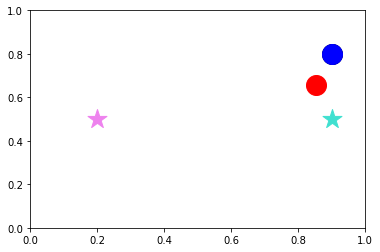

R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet


In [53]:
x = R1.betax
y = R1.betay
#plt.plot(x,y, 'o', c = 'black');
plt.scatter(x,y, s = 400, c = 'black')

x = R2.betax
y = R2.betay
plt.scatter(x, y, s = 400, c = 'red')

x = R3.betax
y = R3.betay
plt.scatter(x, y, s = 400, c = 'blue')

x = T.x
y = T.y
plt.scatter(x, y, s = 400, marker = '*', c = 'turquoise')

x = T2.x
y = T2.y
plt.scatter(x, y, s = 400, marker = '*', c = 'violet')


plt.axis([0, 1, 0, 1])
plt.show() 
print('R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet')

And only NOW, change their rewards according to the new positions! If a robot didn't change the position,
the reward will remain the same.

In [54]:
# the former ones

R1.delta, R2.delta, R3.delta

(0.79, 0.84, 0.8)

In [55]:
# the new ones

R1.delta = reward(T, R1.betax, R1.betay)
print(R1.delta)

R2.delta = reward(T, R2.betax, R2.betay)
print(R2.delta)

R3.delta = reward(T, R3.betax, R3.betay)
print(R3.delta)

0.7
0.84
0.7


In [56]:

# audio 1, R_1

if (R1.betax == 0):
    if (R1.betay == 0.5):
        audio1 = AudioSegment.from_file("notes_/tC.mp3")
        print("tC")
if (R1.betax > 0 and R1.betax <= 0.17):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tB.mp3")
        print("tB")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tC#.mp3")
        print("tC#")
if (R1.betax > 0.17 and R1.betax <= 0.3):
    if (R1.betay < 0.5): # if (R1.betay >= 0.17 and R1.betay < 0.3):
        audio1 = AudioSegment.from_file("notes_/tA#.mp3")
        print("tA#")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tD.mp3")
        print("tD")
if (R1.betax > 0.3 and R1.betax <= 0.5):
    if (R1.betay < 0.5): # (R1.betay == 1):
        audio1 = AudioSegment.from_file("notes_/tD#.mp3")
        print("tD#")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tA.mp3")
        print("tA")
if (R1.betax > 0.5 and R1.betax <= 0.64):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tE.mp3")
        print("tE")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tG#.mp3")
        print("tG#")
if (R1.betax > 0.64 and R1.betax <= 0.84):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tF.mp3")
        print("tF")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tG.mp3")
        print("tG")
if (R1.betax > 0.84 and R1.betax <= 1):
    #if (R1.betay == 0.5):
    audio1 = AudioSegment.from_file("notes_/tF#.mp3")
    print("tF#")
        
# audio 2, R_2      

if (R2.betax == 0):
    if (R2.betay == 0.5):
        audio2 = AudioSegment.from_file("notes_/fC.mp3")
        print("fC")
if (R2.betax > 0 and R2.betax <= 0.17):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fB.mp3")
        print("fB")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fC#.mp3")
        print("fC#")
if (R2.betax > 0.17 and R2.betax <= 0.3):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fA#.mp3")
        print("fA#")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fD.mp3")
        print("fD")
if (R2.betax > 0.3 and R2.betax <= 0.5):
    if (R2.betay < 0.5): # (R1.betay == 1):
        audio2 = AudioSegment.from_file("notes_/fD#.mp3")
        print("fD#")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fA.mp3")
        print("fA")
if (R2.betax > 0.5 and R2.betax <= 0.64):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fE.mp3")
        print("fE")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fG#.mp3")
        print("fG#")
if (R2.betax > 0.64 and R2.betax <= 0.84):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fF.mp3")
        print("fF")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fG.mp3")
        print("fG")
if (R2.betax > 0.84 and R2.betax <= 1):
    #if (R2.betay == 0.5):
    audio2 = AudioSegment.from_file("notes_/fF#.mp3")
    print("fF#")

        
# audio 3, R_3


if (R3.betax == 0):
    if (R3.betay == 0.5):
        audio3 = AudioSegment.from_file("notes_/cC.mp3")
        print("cC")
if (R3.betax > 0 and R3.betax <= 0.17):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cB.mp3")
        print("cB")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cC#.mp3")
        print("cC#")
if (R3.betax > 0.17 and R3.betax <= 0.3):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cA#.mp3")
        print("cA#")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cD.mp3")
        print("cD")
if (R3.betax > 0.3 and R3.betax <= 0.5):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cD#.mp3")
        print("cD#")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cA.mp3")
        print("cA")
if (R3.betax > 0.5 and R3.betax <= 0.64):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cE.mp3")
        print("cE")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cG#.mp3")
        print("cG#")
if (R3.betax > 0.64 and R3.betax <= 0.84):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cF.mp3")
        print("cF")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cG.mp3")
        print("cG")
if (R3.betax > 0.84 and R3.betax <= 1):
    #if (R3.betay == 0.5):
    audio3 = AudioSegment.from_file("notes_/cF#.mp3")
    print("cF#")

mixed_time5_ = audio1.overlay(audio2)          # combine , superimpose audio files
mixed_time5  = mixed_time5_.overlay(audio3)          # further combine , superimpose audio files

mixed_time5.export("notes_/mixed_time5.mp3", format='mp3') # export mixed  audio file
play(mixed_time5) 

tF#
fF#
cF#
Could not import the PyAudio C module '_portaudio'.


Input #0, wav, from '/var/folders/tc/5k6bdv0s421bnc52mnnj7p_w0000gn/T/tmpj4_aqdtp.wav':
  Duration: 00:00:07.34, bitrate: 1411 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, 2 channels, s16, 1411 kb/s


In [57]:
# January 28: SOS with a higher threshold

In [58]:
# Another round of SOS with a higher threshold. Added on January 28

# threshold for initial reward
# random fluctuations

if (R1.delta <= 0.6) and (R2.delta <= 0.6) and (R3.delta <= 0.6):
    print("SOS")
    # R1
    R1.alphax = round(np.random.uniform(0,0.9), 3)
    R1.betax = round(1 - R1.alphax, 3)
    print("the new x-positions for R1 are: ", R1.alphax, R1.betax)
    R1.alphay = round(np.random.uniform(0,0.9), 3)
    R1.betay = round(1 - R1.alphay, 3)
    print("the new y-positions for R1 are: ", R1.alphay, R1.betay)
    # R2
    R2.alphax = round(np.random.uniform(0,0.9), 3)
    R2.betax = round(1 - R2.alphax, 3)
    print("the new x-positions for R2 are: ", R2.alphax, R1.betax)
    R2.alphay = round(np.random.uniform(0,0.9), 3)
    R2.betay = round(1 - R2.alphay, 3)
    print("the new y-positions for R2 are: ", R2.alphay, R1.betay)
    # R3
    R3.alphax = round(np.random.uniform(0,0.9), 3)
    R3.betax = round(1 - R3.alphax, 3)
    print("the new x-positions for R3 are: ", R3.alphax, R1.betax)
    R3.alphay = round(np.random.uniform(0,0.9), 3)
    R3.betay = round(1 - R3.alphay, 3)
    print("the new y-positions for R3 are: ", R3.alphay, R1.betay)
    
R1.delta = reward(T, R1.betax, R1.betay)
R1.gamma = 1 - R1.delta
R2.delta = reward(T, R2.betax, R2.betay)
R2.gamma = 1 - R2.delta
R3.delta = reward(T, R3.betax, R3.betay)
R3.gamma = 1 - R3.delta
print(R1.delta, R2.delta, R3.delta)

0.7 0.84 0.7


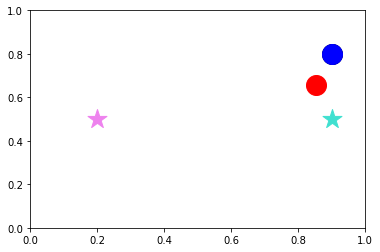

R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet


In [59]:
x = R1.betax
y = R1.betay
#plt.plot(x,y, 'o', c = 'black');
plt.scatter(x,y, s = 400, c = 'black')

x = R2.betax
y = R2.betay
plt.scatter(x, y, s = 400, c = 'red')

x = R3.betax
y = R3.betay
plt.scatter(x, y, s = 400, c = 'blue')

x = T.x
y = T.y
plt.scatter(x, y, s = 400, marker = '*', c = 'turquoise')

x = T2.x
y = T2.y
plt.scatter(x, y, s = 400, marker = '*', c = 'violet')


plt.axis([0, 1, 0, 1])
plt.show() 
print('R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet')

In [60]:

# audio 1, R_1

if (R1.betax == 0):
    if (R1.betay == 0.5):
        audio1 = AudioSegment.from_file("notes_/tC.mp3")
        print("tC")
if (R1.betax > 0 and R1.betax <= 0.17):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tB.mp3")
        print("tB")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tC#.mp3")
        print("tC#")
if (R1.betax > 0.17 and R1.betax <= 0.3):
    if (R1.betay < 0.5): # if (R1.betay >= 0.17 and R1.betay < 0.3):
        audio1 = AudioSegment.from_file("notes_/tA#.mp3")
        print("tA#")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tD.mp3")
        print("tD")
if (R1.betax > 0.3 and R1.betax <= 0.5):
    if (R1.betay < 0.5): # (R1.betay == 1):
        audio1 = AudioSegment.from_file("notes_/tD#.mp3")
        print("tD#")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tA.mp3")
        print("tA")
if (R1.betax > 0.5 and R1.betax <= 0.64):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tE.mp3")
        print("tE")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tG#.mp3")
        print("tG#")
if (R1.betax > 0.64 and R1.betax <= 0.84):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tF.mp3")
        print("tF")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tG.mp3")
        print("tG")
if (R1.betax > 0.84 and R1.betax <= 1):
    #if (R1.betay == 0.5):
    audio1 = AudioSegment.from_file("notes_/tF#.mp3")
    print("tF#")
        
# audio 2, R_2      

if (R2.betax == 0):
    if (R2.betay == 0.5):
        audio2 = AudioSegment.from_file("notes_/fC.mp3")
        print("fC")
if (R2.betax > 0 and R2.betax <= 0.17):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fB.mp3")
        print("fB")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fC#.mp3")
        print("fC#")
if (R2.betax > 0.17 and R2.betax <= 0.3):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fA#.mp3")
        print("fA#")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fD.mp3")
        print("fD")
if (R2.betax > 0.3 and R2.betax <= 0.5):
    if (R2.betay < 0.5): # (R1.betay == 1):
        audio2 = AudioSegment.from_file("notes_/fD#.mp3")
        print("fD#")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fA.mp3")
        print("fA")
if (R2.betax > 0.5 and R2.betax <= 0.64):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fE.mp3")
        print("fE")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fG#.mp3")
        print("fG#")
if (R2.betax > 0.64 and R2.betax <= 0.84):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fF.mp3")
        print("fF")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fG.mp3")
        print("fG")
if (R2.betax > 0.84 and R2.betax <= 1):
    #if (R2.betay == 0.5):
    audio2 = AudioSegment.from_file("notes_/fF#.mp3")
    print("fF#")

        
# audio 3, R_3


if (R3.betax == 0):
    if (R3.betay == 0.5):
        audio3 = AudioSegment.from_file("notes_/cC.mp3")
        print("cC")
if (R3.betax > 0 and R3.betax <= 0.17):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cB.mp3")
        print("cB")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cC#.mp3")
        print("cC#")
if (R3.betax > 0.17 and R3.betax <= 0.3):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cA#.mp3")
        print("cA#")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cD.mp3")
        print("cD")
if (R3.betax > 0.3 and R3.betax <= 0.5):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cD#.mp3")
        print("cD#")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cA.mp3")
        print("cA")
if (R3.betax > 0.5 and R3.betax <= 0.64):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cE.mp3")
        print("cE")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cG#.mp3")
        print("cG#")
if (R3.betax > 0.64 and R3.betax <= 0.84):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cF.mp3")
        print("cF")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cG.mp3")
        print("cG")
if (R3.betax > 0.84 and R3.betax <= 1):
    #if (R3.betay == 0.5):
    audio3 = AudioSegment.from_file("notes_/cF#.mp3")
    print("cF#")

mixed_time6_ = audio1.overlay(audio2)          # combine , superimpose audio files
mixed_time6  = mixed_time6_.overlay(audio3)          # further combine , superimpose audio files

mixed_time6.export("notes_/mixed_time6.mp3", format='mp3') # export mixed  audio file
play(mixed_time6) 

tF#
fF#
cF#
Could not import the PyAudio C module '_portaudio'.


Input #0, wav, from '/var/folders/tc/5k6bdv0s421bnc52mnnj7p_w0000gn/T/tmpwlk0kot8.wav':
  Duration: 00:00:07.34, bitrate: 1411 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, 2 channels, s16, 1411 kb/s


In [61]:
# January 22, 2022

NEW LINES of code: IF the initial reward is very high (greater than 0.8) for at least one of the three robots ("or"), THEN the other robots have to just reach it (with a pretty small fluctuation), without entering the circuit.

In [62]:
if((R1.delta >= 0.8) or (R2.delta >= 0.8) or (R3.delta >= 0.8)):
    print('yuk')
    if (R1.delta > R2.delta and R1.delta > R3.delta):
        print('quokka')
        R2.betax = round(R1.betax + np.random.uniform(0,0.1), 3)
        R2.alphax = round(1 - R2.betax, 3)
        R2.betay = round(R1.betay + np.random.uniform(0,0.1), 3)
        R2.alphay = round(1 - R2.betay, 3)
        R3.betax = round(R1.betax + np.random.uniform(0,0.1), 3)
        R3.alphax = round(1 - R2.betax, 3)
        R3.betay = round(R1.betay + np.random.uniform(0,0.1), 3)
        R3.alphay = round(1 - R2.betay, 3)
    if (R2.delta > R1.delta and R2.delta > R3.delta):
        print('quagga')
        R1.betax = round(R2.betax + np.random.uniform(0,0.1), 3)
        R1.alphax = round(1 - R1.betax, 3)
        R1.betay = round(R2.betay + np.random.uniform(0,0.1), 3)
        R1.alphay = round(1 - R1.betay, 3)
        R3.betax = round(R2.betax + np.random.uniform(0,0.1), 3)
        R3.alphax = round(1 - R3.betax, 3)
        R3.betay = round(R2.betay + np.random.uniform(0,0.1), 3)
        R3.alphay = round(1 - R3.betay, 3)
    if (R3.delta > R1.delta and R3.delta > R2.delta):
        print('quark')
        R1.betax = round(R3.betax + np.random.uniform(0,0.1), 3)
        R1.alphax = round(1 - R1.betax, 3)
        R1.betay = round(R3.betay + np.random.uniform(0,0.1), 3)
        R1.alphay = round(1 - R1.betay, 3)
        R2.betax = round(R3.betax + np.random.uniform(0,0.1), 3)
        R2.alphax = round(1 - R2.betax, 3)
        R2.betay = round(R3.betay + np.random.uniform(0,0.1), 3)
        R2.alphay = round(1 - R2.betay, 3)
        
R1.delta = reward(T, R1.betax, R1.betay)
print(R2.delta)

R2.delta = reward(T, R2.betax, R2.betay)
print(R2.delta)

R3.delta = reward(T, R3.betax, R3.betay)
print(R3.delta)

yuk
quagga
0.84
0.84
0.78


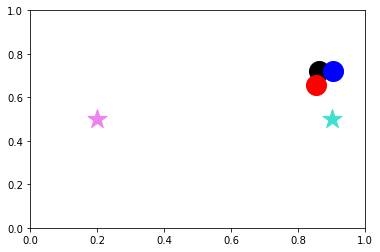

R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet


In [63]:
x = R1.betax
y = R1.betay
#plt.plot(x,y, 'o', c = 'black');
plt.scatter(x,y, s = 400, c = 'black')

x = R2.betax
y = R2.betay
plt.scatter(x, y, s = 400, c = 'red')

x = R3.betax
y = R3.betay
plt.scatter(x, y, s = 400, c = 'blue')

x = T.x
y = T.y
plt.scatter(x, y, s = 400, marker = '*', c = 'turquoise')

x = T2.x
y = T2.y
plt.scatter(x, y, s = 400, marker = '*', c = 'violet')


plt.axis([0, 1, 0, 1])
plt.show() 
print('R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet')

In [64]:

# audio 1, R_1

if (R1.betax == 0):
    if (R1.betay == 0.5):
        audio1 = AudioSegment.from_file("notes_/tC.mp3")
        print("tC")
if (R1.betax > 0 and R1.betax <= 0.17):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tB.mp3")
        print("tB")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tC#.mp3")
        print("tC#")
if (R1.betax > 0.17 and R1.betax <= 0.3):
    if (R1.betay < 0.5): # if (R1.betay >= 0.17 and R1.betay < 0.3):
        audio1 = AudioSegment.from_file("notes_/tA#.mp3")
        print("tA#")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tD.mp3")
        print("tD")
if (R1.betax > 0.3 and R1.betax <= 0.5):
    if (R1.betay < 0.5): # (R1.betay == 1):
        audio1 = AudioSegment.from_file("notes_/tD#.mp3")
        print("tD#")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tA.mp3")
        print("tA")
if (R1.betax > 0.5 and R1.betax <= 0.64):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tE.mp3")
        print("tE")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tG#.mp3")
        print("tG#")
if (R1.betax > 0.64 and R1.betax <= 0.84):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tF.mp3")
        print("tF")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tG.mp3")
        print("tG")
if (R1.betax > 0.84 and R1.betax <= 1):
    #if (R1.betay == 0.5):
    audio1 = AudioSegment.from_file("notes_/tF#.mp3")
    print("tF#")
        
# audio 2, R_2      

if (R2.betax == 0):
    if (R2.betay == 0.5):
        audio2 = AudioSegment.from_file("notes_/fC.mp3")
        print("fC")
if (R2.betax > 0 and R2.betax <= 0.17):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fB.mp3")
        print("fB")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fC#.mp3")
        print("fC#")
if (R2.betax > 0.17 and R2.betax <= 0.3):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fA#.mp3")
        print("fA#")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fD.mp3")
        print("fD")
if (R2.betax > 0.3 and R2.betax <= 0.5):
    if (R2.betay < 0.5): # (R1.betay == 1):
        audio2 = AudioSegment.from_file("notes_/fD#.mp3")
        print("fD#")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fA.mp3")
        print("fA")
if (R2.betax > 0.5 and R2.betax <= 0.64):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fE.mp3")
        print("fE")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fG#.mp3")
        print("fG#")
if (R2.betax > 0.64 and R2.betax <= 0.84):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fF.mp3")
        print("fF")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fG.mp3")
        print("fG")
if (R2.betax > 0.84 and R2.betax <= 1):
    #if (R2.betay == 0.5):
    audio2 = AudioSegment.from_file("notes_/fF#.mp3")
    print("fF#")

        
# audio 3, R_3


if (R3.betax == 0):
    if (R3.betay == 0.5):
        audio3 = AudioSegment.from_file("notes_/cC.mp3")
        print("cC")
if (R3.betax > 0 and R3.betax <= 0.17):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cB.mp3")
        print("cB")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cC#.mp3")
        print("cC#")
if (R3.betax > 0.17 and R3.betax <= 0.3):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cA#.mp3")
        print("cA#")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cD.mp3")
        print("cD")
if (R3.betax > 0.3 and R3.betax <= 0.5):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cD#.mp3")
        print("cD#")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cA.mp3")
        print("cA")
if (R3.betax > 0.5 and R3.betax <= 0.64):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cE.mp3")
        print("cE")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cG#.mp3")
        print("cG#")
if (R3.betax > 0.64 and R3.betax <= 0.84):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cF.mp3")
        print("cF")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cG.mp3")
        print("cG")
if (R3.betax > 0.84 and R3.betax <= 1):
    #if (R3.betay == 0.5):
    audio3 = AudioSegment.from_file("notes_/cF#.mp3")
    print("cF#")
        
mixed_time7_ = audio1.overlay(audio2)          # combine , superimpose audio files
mixed_time7  = mixed_time7_.overlay(audio3)          # further combine , superimpose audio files

mixed_time7.export("notes_/mixed_time7.mp3", format='mp3') # export mixed  audio file
play(mixed_time7) 

tF#
fF#
cF#
Could not import the PyAudio C module '_portaudio'.


Input #0, wav, from '/var/folders/tc/5k6bdv0s421bnc52mnnj7p_w0000gn/T/tmpdf1fvcps.wav':
  Duration: 00:00:07.34, bitrate: 1411 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, 2 channels, s16, 1411 kb/s


Now, all robots reach the robot with the highest reward, with fluctuations:

In [65]:
if (R1.delta > R2.delta) and (R1.delta > R2.delta): # now, brutally come close to the robot with the highest reward & fluctuate
    print("ciao")
    # change R2, R3 but not R1
    # R2
    R2.alphax = round(R1.alphax + np.random.uniform(0,0.1), 3) 
    R2.betax = round(1 - R2.alphax, 3)
    R2.alphay = round(R1.alphax + np.random.uniform(0,0.1), 3)
    R2.betay = round(1 - R2.alphax, 3)
    # R3
    R3.alphax = round(R1.alphax + np.random.uniform(0,0.1), 3)
    R3.betax = round(1 - R2.alphax, 3)
    R3.alphay = round(R1.alphax + np.random.uniform(0,0.1), 3)
    R3.betay = round(1 - R2.alphax, 3)
elif (R2.delta > R3.delta) and (R2.delta > R3.delta):
    print("glu glu")
    # change R1, R3 but not R2
    # R1
    R1.alphax = round(R2.alphax + np.random.uniform(0,0.1), 3)
    R1.betax = round(1 - R1.alphax, 3)
    R1.alphay = round(R2.alphay + np.random.uniform(0,0.1), 3)
    R1.betay = round(1 - R1.alphay, 3)
    # R3
    R3.alphax = round(R2.alphax + np.random.uniform(0,0.1), 3)
    R3.betax = round(1 - R2.alphax, 3)
    R3.alphay = round(R2.alphax + np.random.uniform(0,0.1), 3)
    R3.betay = round(1 - R2.alphax, 3)
elif (R3.delta > R1.delta) and (R3.delta > R2.delta):
    print("cri cri")
    # change R1, R2 but nor R3
    # R1
    R1.alphax = round(R3.alphax + np.random.uniform(0,0.1), 3)
    R1.betax = round(1 - R1.alphax, 3)
    R1.alphay = round(R3.alphay + np.random.uniform(0,0.1), 3)
    R1.betay = round(1 - R1.alphay, 3)
    # R2
    R2.alphax = round(R3.alphax + np.random.uniform(0,0.1), 3)
    R2.betax = round(1 - R2.alphax, 3)
    R2.alphay = round(R3.alphax + np.random.uniform(0,0.1), 3)
    R2.betay = round(1 - R2.alphax, 3)

glu glu


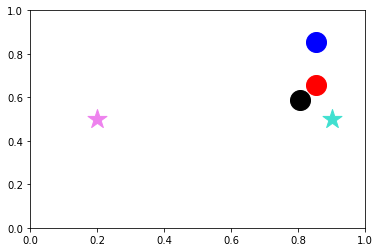

R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet


In [66]:
x = R1.betax
y = R1.betay
#plt.plot(x,y, 'o', c = 'black');
plt.scatter(x,y, s = 400, c = 'black')

x = R2.betax
y = R2.betay
plt.scatter(x, y, s = 400, c = 'red')

x = R3.betax
y = R3.betay
plt.scatter(x, y, s = 400, c = 'blue')

x = T.x
y = T.y
plt.scatter(x, y, s = 400, marker = '*', c = 'turquoise')

x = T2.x
y = T2.y
plt.scatter(x, y, s = 400, marker = '*', c = 'violet')


plt.axis([0, 1, 0, 1])
plt.show() 
print('R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet')

In [67]:

# audio 1, R_1

if (R1.betax == 0):
    if (R1.betay == 0.5):
        audio1 = AudioSegment.from_file("notes_/tC.mp3")
        print("tC")
if (R1.betax > 0 and R1.betax <= 0.17):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tB.mp3")
        print("tB")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tC#.mp3")
        print("tC#")
if (R1.betax > 0.17 and R1.betax <= 0.3):
    if (R1.betay < 0.5): # if (R1.betay >= 0.17 and R1.betay < 0.3):
        audio1 = AudioSegment.from_file("notes_/tA#.mp3")
        print("tA#")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tD.mp3")
        print("tD")
if (R1.betax > 0.3 and R1.betax <= 0.5):
    if (R1.betay < 0.5): # (R1.betay == 1):
        audio1 = AudioSegment.from_file("notes_/tD#.mp3")
        print("tD#")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tA.mp3")
        print("tA")
if (R1.betax > 0.5 and R1.betax <= 0.64):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tE.mp3")
        print("tE")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tG#.mp3")
        print("tG#")
if (R1.betax > 0.64 and R1.betax <= 0.84):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tF.mp3")
        print("tF")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tG.mp3")
        print("tG")
if (R1.betax > 0.84 and R1.betax <= 1):
    #if (R1.betay == 0.5):
    audio1 = AudioSegment.from_file("notes_/tF#.mp3")
    print("tF#")
        
# audio 2, R_2      

if (R2.betax == 0):
    if (R2.betay == 0.5):
        audio2 = AudioSegment.from_file("notes_/fC.mp3")
        print("fC")
if (R2.betax > 0 and R2.betax <= 0.17):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fB.mp3")
        print("fB")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fC#.mp3")
        print("fC#")
if (R2.betax > 0.17 and R2.betax <= 0.3):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fA#.mp3")
        print("fA#")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fD.mp3")
        print("fD")
if (R2.betax > 0.3 and R2.betax <= 0.5):
    if (R2.betay < 0.5): # (R1.betay == 1):
        audio2 = AudioSegment.from_file("notes_/fD#.mp3")
        print("fD#")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fA.mp3")
        print("fA")
if (R2.betax > 0.5 and R2.betax <= 0.64):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fE.mp3")
        print("fE")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fG#.mp3")
        print("fG#")
if (R2.betax > 0.64 and R2.betax <= 0.84):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fF.mp3")
        print("fF")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fG.mp3")
        print("fG")
if (R2.betax > 0.84 and R2.betax <= 1):
    #if (R2.betay == 0.5):
    audio2 = AudioSegment.from_file("notes_/fF#.mp3")
    print("fF#")

        
# audio 3, R_3


if (R3.betax == 0):
    if (R3.betay == 0.5):
        audio3 = AudioSegment.from_file("notes_/cC.mp3")
        print("cC")
if (R3.betax > 0 and R3.betax <= 0.17):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cB.mp3")
        print("cB")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cC#.mp3")
        print("cC#")
if (R3.betax > 0.17 and R3.betax <= 0.3):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cA#.mp3")
        print("cA#")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cD.mp3")
        print("cD")
if (R3.betax > 0.3 and R3.betax <= 0.5):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cD#.mp3")
        print("cD#")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cA.mp3")
        print("cA")
if (R3.betax > 0.5 and R3.betax <= 0.64):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cE.mp3")
        print("cE")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cG#.mp3")
        print("cG#")
if (R3.betax > 0.64 and R3.betax <= 0.84):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cF.mp3")
        print("cF")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cG.mp3")
        print("cG")
if (R3.betax > 0.84 and R3.betax <= 1):
    #if (R3.betay == 0.5):
    audio3 = AudioSegment.from_file("notes_/cF#.mp3")
    print("cF#")

mixed_time8_ = audio1.overlay(audio2)          # combine , superimpose audio files
mixed_time8  = mixed_time8_.overlay(audio3)          # further combine , superimpose audio files

mixed_time8.export("notes_/mixed_time8.mp3", format='mp3') # export mixed  audio file
play(mixed_time8) 

tG
fF#
cF#
Could not import the PyAudio C module '_portaudio'.


Input #0, wav, from '/var/folders/tc/5k6bdv0s421bnc52mnnj7p_w0000gn/T/tmpbyt7jwq2.wav':
  Duration: 00:00:07.34, bitrate: 1411 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, 2 channels, s16, 1411 kb/s


Let us now update $\gamma,\,\delta_i,\,i=1,2,3$ according to the target (fixed) positions and the new positions.

New reward amplitude probabilities for $R_1$:

In [68]:
R1.delta = reward(T,R1.betax,R1.betay)
R1.gamma = round((1 - R1.delta),3)
print(R1.delta)

0.87


New reward amplitude probabilities for $R_2$:

In [69]:
R2.delta = reward(T,R2.betax,R2.betay)
R2.gamma = round((1 - R2.delta),3)
print(R2.delta)

0.84


New reward amplitude probabilities for $R_3$:

In [70]:
R3.delta = reward(T,R3.betax,R3.betay)
R3.gamma = round((1 - R3.delta),3)
print(R3.delta)

0.64


In [71]:
# January 22, 2022

NEW LINES of code: IF the initial reward is very high (greater than 0.8) for at least one of the three robots ("or"), THEN the other robots have to just reach it (with a pretty small fluctuation), without entering the circuit.



In [72]:

if((R1.delta >= 0.8) or (R2.delta >= 0.8) or (R3.delta >= 0.8)):
    print('yuk')
    if (R1.delta > R2.delta and R1.delta > R3.delta):
        print('quokka')
        R2.betax = round(R1.betax + np.random.uniform(0,0.1), 3)
        R2.alphax = round(1 - R2.betax, 3)
        R2.betay = round(R1.betay + np.random.uniform(0,0.1), 3)
        R2.alphay = round(1 - R2.betay, 3)
        R3.betax = round(R1.betax + np.random.uniform(0,0.1), 3)
        R3.alphax = round(1 - R2.betax, 3)
        R3.betay = round(R1.betay + np.random.uniform(0,0.1), 3)
        R3.alphay = round(1 - R2.betay, 3)
    if (R2.delta > R1.delta and R2.delta > R3.delta):
        print('quagga')
        R1.betax = round(R2.betax + np.random.uniform(0,0.1), 3)
        R1.alphax = round(1 - R1.betax, 3)
        R1.betay = round(R2.betay + np.random.uniform(0,0.1), 3)
        R1.alphay = round(1 - R1.betay, 3)
        R3.betax = round(R2.betax + np.random.uniform(0,0.1), 3)
        R3.alphax = round(1 - R3.betax, 3)
        R3.betay = round(R2.betay + np.random.uniform(0,0.1), 3)
        R3.alphay = round(1 - R3.betay, 3)
    if (R3.delta > R1.delta and R3.delta > R2.delta):
        print('quark')
        R1.betax = round(R3.betax + np.random.uniform(0,0.1), 3)
        R1.alphax = round(1 - R1.betax, 3)
        R1.betay = round(R3.betay + np.random.uniform(0,0.1), 3)
        R1.alphay = round(1 - R1.betay, 3)
        R2.betax = round(R3.betax + np.random.uniform(0,0.1), 3)
        R2.alphax = round(1 - R2.betax, 3)
        R2.betay = round(R3.betay + np.random.uniform(0,0.1), 3)
        R2.alphay = round(1 - R2.betay, 3)
        
R1.delta = reward(T, R1.betax, R1.betay)
print(R2.delta)

R2.delta = reward(T, R2.betax, R2.betay)
print(R2.delta)

R3.delta = reward(T, R3.betax, R3.betay)
print(R3.delta)

yuk
quokka
0.84
0.8
0.84


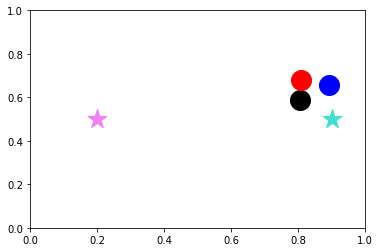

R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet


In [73]:
x = R1.betax
y = R1.betay
#plt.plot(x,y, 'o', c = 'black');
plt.scatter(x,y, s = 400, c = 'black')

x = R2.betax
y = R2.betay
plt.scatter(x, y, s = 400, c = 'red')

x = R3.betax
y = R3.betay
plt.scatter(x, y, s = 400, c = 'blue')

x = T.x
y = T.y
plt.scatter(x, y, s = 400, marker = '*', c = 'turquoise')

x = T2.x
y = T2.y
plt.scatter(x, y, s = 400, marker = '*', c = 'violet')


plt.axis([0, 1, 0, 1])
plt.show() 
print('R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet')

In [74]:

# audio 1, R_1

if (R1.betax == 0):
    if (R1.betay == 0.5):
        audio1 = AudioSegment.from_file("notes_/tC.mp3")
        print("tC")
if (R1.betax > 0 and R1.betax <= 0.17):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tB.mp3")
        print("tB")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tC#.mp3")
        print("tC#")
if (R1.betax > 0.17 and R1.betax <= 0.3):
    if (R1.betay < 0.5): # if (R1.betay >= 0.17 and R1.betay < 0.3):
        audio1 = AudioSegment.from_file("notes_/tA#.mp3")
        print("tA#")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tD.mp3")
        print("tD")
if (R1.betax > 0.3 and R1.betax <= 0.5):
    if (R1.betay < 0.5): # (R1.betay == 1):
        audio1 = AudioSegment.from_file("notes_/tD#.mp3")
        print("tD#")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tA.mp3")
        print("tA")
if (R1.betax > 0.5 and R1.betax <= 0.64):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tE.mp3")
        print("tE")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tG#.mp3")
        print("tG#")
if (R1.betax > 0.64 and R1.betax <= 0.84):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tF.mp3")
        print("tF")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tG.mp3")
        print("tG")
if (R1.betax > 0.84 and R1.betax <= 1):
    #if (R1.betay == 0.5):
    audio1 = AudioSegment.from_file("notes_/tF#.mp3")
    print("tF#")
        
# audio 2, R_2      

if (R2.betax == 0):
    if (R2.betay == 0.5):
        audio2 = AudioSegment.from_file("notes_/fC.mp3")
        print("fC")
if (R2.betax > 0 and R2.betax <= 0.17):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fB.mp3")
        print("fB")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fC#.mp3")
        print("fC#")
if (R2.betax > 0.17 and R2.betax <= 0.3):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fA#.mp3")
        print("fA#")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fD.mp3")
        print("fD")
if (R2.betax > 0.3 and R2.betax <= 0.5):
    if (R2.betay < 0.5): # (R1.betay == 1):
        audio2 = AudioSegment.from_file("notes_/fD#.mp3")
        print("fD#")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fA.mp3")
        print("fA")
if (R2.betax > 0.5 and R2.betax <= 0.64):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fE.mp3")
        print("fE")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fG#.mp3")
        print("fG#")
if (R2.betax > 0.64 and R2.betax <= 0.84):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fF.mp3")
        print("fF")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fG.mp3")
        print("fG")
if (R2.betax > 0.84 and R2.betax <= 1):
    #if (R2.betay == 0.5):
    audio2 = AudioSegment.from_file("notes_/fF#.mp3")
    print("fF#")

        
# audio 3, R_3


if (R3.betax == 0):
    if (R3.betay == 0.5):
        audio3 = AudioSegment.from_file("notes_/cC.mp3")
        print("cC")
if (R3.betax > 0 and R3.betax <= 0.17):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cB.mp3")
        print("cB")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cC#.mp3")
        print("cC#")
if (R3.betax > 0.17 and R3.betax <= 0.3):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cA#.mp3")
        print("cA#")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cD.mp3")
        print("cD")
if (R3.betax > 0.3 and R3.betax <= 0.5):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cD#.mp3")
        print("cD#")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cA.mp3")
        print("cA")
if (R3.betax > 0.5 and R3.betax <= 0.64):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cE.mp3")
        print("cE")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cG#.mp3")
        print("cG#")
if (R3.betax > 0.64 and R3.betax <= 0.84):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cF.mp3")
        print("cF")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cG.mp3")
        print("cG")
if (R3.betax > 0.84 and R3.betax <= 1):
    #if (R3.betay == 0.5):
    audio3 = AudioSegment.from_file("notes_/cF#.mp3")
    print("cF#")

mixed_time9_ = audio1.overlay(audio2)          # combine , superimpose audio files
mixed_time9  = mixed_time9_.overlay(audio3)          # further combine , superimpose audio files

mixed_time9.export("notes_/mixed_time9.mp3", format='mp3') # export mixed  audio file
play(mixed_time9) 

tG
fG
cF#
Could not import the PyAudio C module '_portaudio'.


Input #0, wav, from '/var/folders/tc/5k6bdv0s421bnc52mnnj7p_w0000gn/T/tmpf6gjb895.wav':
  Duration: 00:00:07.34, bitrate: 1411 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, 2 channels, s16, 1411 kb/s


Let us now try to use entanglement, teleportation, or what is needed, to somehow `glue' together two or more robots which are pretty close to the target.

In [75]:
# to be improved: probabilistic representation of positions for more position-uncertain states...
# Python probability plot???

When we measure the position of $R_1$ and we get 1, 1, also $R_2$ are $R_3$ in 1, 1. If we measure and we get 0, 0, also $R_2$, $R_3$ are in 0, 0. In the following code lines, I separated x, y for clarity, but the idea is the same. In this way, we create an entangled GHZ state $\frac{1}{\sqrt{2}}(|11111\rangle + |00000\rangle)$, where the qubits indicate x- and y-positions. Reward is not included in this discussion, because this section is activated only if all robots present almost the same reward (here, pairwise difference $\leq 0.1$). 

In [76]:
# a new circuit
q = QuantumRegister(9, 'q'); # qubits
#c0 = ClassicalRegister(6, 'c0');
c0 = ClassicalRegister(1, 'c0');
c1 = ClassicalRegister(1, 'c1');
c3 = ClassicalRegister(1, 'c3');
c4 = ClassicalRegister(1, 'c4');
c6 = ClassicalRegister(1, 'c6');
c7 = ClassicalRegister(1, 'c7');
qc_small = QuantumCircuit(q, c0, c1, c3, c4, c6, c7);

In [77]:
if ((R3.delta - R2.delta) <= 0.3) and ((R3.delta - R1.delta) <= 0.3) and ((R2.delta - R1.delta) <= 0.3):
    # 0.3 rather than 0.1
    print("cometa")# GHZ for all
    qc_small.h(q[0]) # Hadamard
    qc_small.cx(q[0], q[1]) # CNOT
    qc_small.cx(q[0], q[2]) # CNOT
    qc_small.cx(q[0], q[3]) # CNOT
    qc_small.cx(q[0], q[4]) # CNOT
    qc_small.cx(q[0], q[5]) # CNOT
    qc_small.cx(q[0], q[6]) # CNOT
    qc_small.cx(q[0], q[7]) # CNOT
    # barrier
    qc_small.barrier(q[0], q[1], q[2], q[3], q[4], q[5], q[6], q[7])
    # measures
    qc_small.measure(q[0],c0[0])
    qc_small.measure(q[3],c3[0])
    qc_small.measure(q[6],c6[0])
    qc_small.measure(q[1],c1[0])
    qc_small.measure(q[4],c4[0])
    qc_small.measure(q[7],c7[0])
    # draw circuit
    draw_circuit(qc_small)
    # definition of quantum simulator
    simulator = Aer.get_backend('qasm_simulator') # statevector_simulator # aer_simulator # qasm_simulator
    qc_small = transpile(qc_small, simulator)
    # Run and get counts
    result = simulator.run(qc_small, shots=1024).result()
    counts_GHZ_all = result.get_counts(qc_small)
    counts_GHZ = counts_GHZ_all.most_frequent() # does not work if multiple states have the same counts
    # decide something if multiple states have the same count --> e.g., ``choose the first''
    print(counts_GHZ_all)
    print(counts_GHZ)
    #plot_histogram(counts_GHZ_all, title='outcomes')
    #plot_histogram(counts_GHZ, title='outcomes')

cometa


CircuitComposer(circuit=<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fbc4471ba90>, editable=Fals…

{'1 1 1 1 1 1': 518, '0 0 0 0 0 0': 506}
1 1 1 1 1 1


In [78]:
print(counts_GHZ) # order: R3, R2, R1. Add some uncertainty?
# export as an array
str_ = counts_GHZ
arr_GHZ = str_.split(' ') # to split the string and avoid empty spaces as array elements
print(arr_GHZ)
# We do not need to update rewards; they should be done externally... excluded str[0], str[3], str[6]

1 1 1 1 1 1
['1', '1', '1', '1', '1', '1']


Define the 'new 0':

In [79]:
if (R1.delta >= R2.delta) and (R1.delta >= R3.delta):
    print('gosh')
    new_zero_betax = R1.betax + np.random.uniform(0,0.1)
    new_zero_alphax = 1 - R1.betax
    new_zero_betay = R1.betay + np.random.uniform(0,0.1)
    new_zero_alphay = 1 - R2.betay + np.random.uniform(0,0.1)

if (R2.delta >= R1.delta) and (R2.delta >= R3.delta):
    print('kinda')
    new_zero_betax = R2.betax + np.random.uniform(0,0.1)
    new_zero_alphax = 1 - R2.betax
    new_zero_betay = R2.betay + np.random.uniform(0,0.1)
    new_zero_alphay = 1 - R2.betay

if (R3.delta >= R2.delta) and (R3.delta >= R1.delta):
    print('uffdah')
    new_zero_betax = R3.betax + np.random.uniform(0,0.1)
    new_zero_alphax = 1 - R3.betax
    new_zero_betay = R3.betay + np.random.uniform(0,0.1)
    new_zero_alphay = 1 - R3.betay

gosh


Define the 'new 1':

In [80]:
# flip thanks to the 'minus' sign?
# I had tried with if(R1... < R2...) etc., but it is not ok,
# because we need to initialize all elements.

if (R1.delta >= R2.delta) and (R1.delta >= R3.delta):
    print('gosh')
    new_one_betax = R1.betax - np.random.uniform(0,0.1)
    new_one_alphax = 1 - R1.betax
    new_one_betay = R1.betay - np.random.uniform(0,0.1)
    new_one_alphay = 1 - R2.betay

if (R2.delta >= R1.delta) and (R2.delta >= R3.delta):
    print('kinda')
    new_one_betax = R2.betax - np.random.uniform(0,0.1)
    new_one_alphax = 1 - R2.betax
    new_one_betay = R2.betay - np.random.uniform(0,0.1)
    new_one_alphay = 1 - R2.betay

if (R3.delta >= R2.delta) and (R3.delta >= R1.delta):
    print('uffdah')
    new_one_betax = R3.betax - np.random.uniform(0,0.1)
    new_one_alphax = 1 - R3.betax
    new_one_betay = R3.betay - np.random.uniform(0,0.1)
    new_one_alphay = 1 - R3.betay

gosh


Choose the 'new 0' or the 'new 1' according to the outcome of GHZ circuit:

In [81]:
if (arr_GHZ[0] =='0'):
    R1.alphax = new_zero_alphax
    R1.betax = new_zero_betax
if (arr_GHZ[1] =='0'):
    R1.alphay = new_zero_alphay
    R1.betay = new_zero_betay
if (arr_GHZ[2] =='0'):
    R2.alphax = new_zero_alphax
    R2.betax = new_zero_betax
if (arr_GHZ[3] =='0'):
    R2.alphay = new_zero_alphay
    R2.betay = new_zero_betay
if (arr_GHZ[3] =='0'):
    R2.alphax = new_zero_alphax
    R2.betax = new_zero_betax
if (arr_GHZ[4] =='0'):
    R3.alphax = new_zero_alphax
    R3.betax = new_zero_betax
if (arr_GHZ[5] =='0'):
    R3.alphay = new_zero_alphay
    R3.betay = new_zero_betay

    
if (arr_GHZ[0] =='1'):
    R1.alphax = new_one_alphax
    R1.betax = new_one_betax
if (arr_GHZ[1] =='1'):
    R1.alphay = new_one_alphay
    R1.betay = new_one_betay
if (arr_GHZ[2] =='1'):
    R2.alphax = new_one_alphax
    R2.betax = new_one_betax
if (arr_GHZ[3] =='1'):
    R2.alphay = new_one_alphay
    R2.betay = new_one_betay
if (arr_GHZ[3] =='1'):
    R2.alphax = new_one_alphax
    R2.betax = new_one_betax
if (arr_GHZ[4] =='1'):
    R3.alphax = new_one_alphax
    R3.betax = new_one_betax
if (arr_GHZ[5] =='1'):
    R3.alphay = new_one_alphay
    R3.betay = new_one_betay


if (arr_GHZ[0] =='0'): # all the other bits are supposed to be equal in GHZ.........
    R3.alphax = new_zero_alphax
    R3.betax = new_zero_betax
    R2.alphax = new_zero_alphax
    R2.betax = new_zero_betax
    R1.alphax = new_zero_alphax
    R1.betax = new_zero_betax
if (arr_GHZ[0] =='1'):
    R3.alphax = new_zero_alphax
    R3.betax = new_zero_betax
    R2.alphax = new_zero_alphax
    R2.betax = new_zero_betax
    R1.alphax = new_zero_alphax
    R1.betax = new_zero_betax

New reward for $R_1$:

In [82]:
R1.delta = reward(T,R1.betax,R1.betay)
R1.gamma = round((1 - R1.delta),2)
print(R1.delta)

0.85


New reward for $R_2$:

In [83]:
R2.delta = reward(T,R2.betax,R2.betay)
R2.gamma = round((1 - R2.delta),2)
print(R2.delta)

0.85


New reward for $R_3$:

In [84]:
R3.delta = reward(T,R3.betax,R3.betay)
R3.gamma = round((1 - R3.delta),2)
print(R3.delta)

0.85


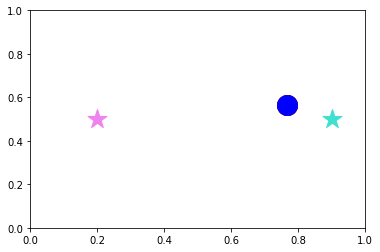

R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet


In [85]:
x = R1.betax
y = R1.betay
#plt.plot(x,y, 'o', c = 'black');
plt.scatter(x,y, s = 400, c = 'black')

x = R2.betax
y = R2.betay
plt.scatter(x, y, s = 400, c = 'red')

x = R3.betax
y = R3.betay
plt.scatter(x, y, s = 400, c = 'blue')

x = T.x
y = T.y
plt.scatter(x, y, s = 400, marker = '*', c = 'turquoise')

x = T2.x
y = T2.y
plt.scatter(x, y, s = 400, marker = '*', c = 'violet')


plt.axis([0, 1, 0, 1])
plt.show() 
print('R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet')

In [86]:

# audio 1, R_1

if (R1.betax == 0):
    if (R1.betay == 0.5):
        audio1 = AudioSegment.from_file("notes_/tC.mp3")
        print("tC")
if (R1.betax > 0 and R1.betax <= 0.17):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tB.mp3")
        print("tB")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tC#.mp3")
        print("tC#")
if (R1.betax > 0.17 and R1.betax <= 0.3):
    if (R1.betay < 0.5): # if (R1.betay >= 0.17 and R1.betay < 0.3):
        audio1 = AudioSegment.from_file("notes_/tA#.mp3")
        print("tA#")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tD.mp3")
        print("tD")
if (R1.betax > 0.3 and R1.betax <= 0.5):
    if (R1.betay < 0.5): # (R1.betay == 1):
        audio1 = AudioSegment.from_file("notes_/tD#.mp3")
        print("tD#")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tA.mp3")
        print("tA")
if (R1.betax > 0.5 and R1.betax <= 0.64):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tE.mp3")
        print("tE")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tG#.mp3")
        print("tG#")
if (R1.betax > 0.64 and R1.betax <= 0.84):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tF.mp3")
        print("tF")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tG.mp3")
        print("tG")
if (R1.betax > 0.84 and R1.betax <= 1):
    #if (R1.betay == 0.5):
    audio1 = AudioSegment.from_file("notes_/tF#.mp3")
    print("tF#")
        
# audio 2, R_2      

if (R2.betax == 0):
    if (R2.betay == 0.5):
        audio2 = AudioSegment.from_file("notes_/fC.mp3")
        print("fC")
if (R2.betax > 0 and R2.betax <= 0.17):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fB.mp3")
        print("fB")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fC#.mp3")
        print("fC#")
if (R2.betax > 0.17 and R2.betax <= 0.3):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fA#.mp3")
        print("fA#")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fD.mp3")
        print("fD")
if (R2.betax > 0.3 and R2.betax <= 0.5):
    if (R2.betay < 0.5): # (R1.betay == 1):
        audio2 = AudioSegment.from_file("notes_/fD#.mp3")
        print("fD#")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fA.mp3")
        print("fA")
if (R2.betax > 0.5 and R2.betax <= 0.64):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fE.mp3")
        print("fE")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fG#.mp3")
        print("fG#")
if (R2.betax > 0.64 and R2.betax <= 0.84):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fF.mp3")
        print("fF")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fG.mp3")
        print("fG")
if (R2.betax > 0.84 and R2.betax <= 1):
    #if (R2.betay == 0.5):
    audio2 = AudioSegment.from_file("notes_/fF#.mp3")
    print("fF#")

        
# audio 3, R_3


if (R3.betax == 0):
    if (R3.betay == 0.5):
        audio3 = AudioSegment.from_file("notes_/cC.mp3")
        print("cC")
if (R3.betax > 0 and R3.betax <= 0.17):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cB.mp3")
        print("cB")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cC#.mp3")
        print("cC#")
if (R3.betax > 0.17 and R3.betax <= 0.3):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cA#.mp3")
        print("cA#")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cD.mp3")
        print("cD")
if (R3.betax > 0.3 and R3.betax <= 0.5):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cD#.mp3")
        print("cD#")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cA.mp3")
        print("cA")
if (R3.betax > 0.5 and R3.betax <= 0.64):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cE.mp3")
        print("cE")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cG#.mp3")
        print("cG#")
if (R3.betax > 0.64 and R3.betax <= 0.84):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cF.mp3")
        print("cF")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cG.mp3")
        print("cG")
if (R3.betax > 0.84 and R3.betax <= 1):
    #if (R3.betay == 0.5):
    audio3 = AudioSegment.from_file("notes_/cF#.mp3")
    print("cF#")

mixed_time10_ = audio1.overlay(audio2)          # combine , superimpose audio files
mixed_time10  = mixed_time10_.overlay(audio3)          # further combine , superimpose audio files

mixed_time10.export("notes_/mixed_time10.mp3", format='mp3') # export mixed  audio file
play(mixed_time10) 

tG
fG
cG
Could not import the PyAudio C module '_portaudio'.


Input #0, wav, from '/var/folders/tc/5k6bdv0s421bnc52mnnj7p_w0000gn/T/tmpn643z79v.wav':
  Duration: 00:00:07.34, bitrate: 1411 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, 2 channels, s16, 1411 kb/s


In [87]:
R1.delta, R2.delta, R3.delta

(0.85, 0.85, 0.85)

In [88]:
# January 22, 2022

NEW LINES of code: IF the initial reward is very high (greater than 0.8) for at least one of the three robots ("or"), THEN the other robots have to just reach it (with a pretty small fluctuation), without entering the circuit.


In [89]:

if((R1.delta >= 0.8) or (R2.delta >= 0.8) or (R3.delta >= 0.8)):
    print('yuk')
    if (R1.delta > R2.delta and R1.delta > R3.delta):
        print('quokka')
        R2.betax = round(R1.betax + np.random.uniform(0,0.1), 3)
        R2.alphax = round(1 - R2.betax, 3)
        R2.betay = round(R1.betay + np.random.uniform(0,0.1), 3)
        R2.alphay = round(1 - R2.betay, 3)
        R3.betax = round(R1.betax + np.random.uniform(0,0.1), 3)
        R3.alphax = round(1 - R2.betax, 3)
        R3.betay = round(R1.betay + np.random.uniform(0,0.1), 3)
        R3.alphay = round(1 - R2.betay, 3)
    if (R2.delta > R1.delta and R2.delta > R3.delta):
        print('quagga')
        R1.betax = round(R2.betax + np.random.uniform(0,0.1), 3)
        R1.alphax = round(1 - R1.betax, 3)
        R1.betay = round(R2.betay + np.random.uniform(0,0.1), 3)
        R1.alphay = round(1 - R1.betay, 3)
        R3.betax = round(R2.betax + np.random.uniform(0,0.1), 3)
        R3.alphax = round(1 - R3.betax, 3)
        R3.betay = round(R2.betay + np.random.uniform(0,0.1), 3)
        R3.alphay = round(1 - R3.betay, 3)
    if (R3.delta > R1.delta and R3.delta > R2.delta):
        print('quark')
        R1.betax = round(R3.betax + np.random.uniform(0,0.1), 3)
        R1.alphax = round(1 - R1.betax, 3)
        R1.betay = round(R3.betay + np.random.uniform(0,0.1), 3)
        R1.alphay = round(1 - R1.betay, 3)
        R2.betax = round(R3.betax + np.random.uniform(0,0.1), 3)
        R2.alphax = round(1 - R2.betax, 3)
        R2.betay = round(R3.betay + np.random.uniform(0,0.1), 3)
        R2.alphay = round(1 - R2.betay, 3)
        
R1.delta = reward(T, R1.betax, R1.betay)
print(R2.delta)

R2.delta = reward(T, R2.betax, R2.betay)
print(R2.delta)

R3.delta = reward(T, R3.betax, R3.betay)
print(R2.delta)

yuk
0.85
0.85
0.85


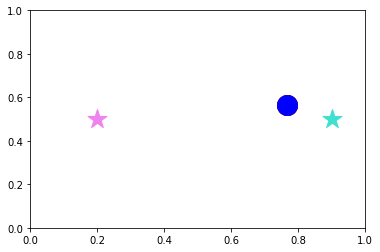

R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet


In [90]:
x = R1.betax
y = R1.betay
#plt.plot(x,y, 'o', c = 'black');
plt.scatter(x,y, s = 400, c = 'black')

x = R2.betax
y = R2.betay
plt.scatter(x, y, s = 400, c = 'red')

x = R3.betax
y = R3.betay
plt.scatter(x, y, s = 400, c = 'blue')

x = T.x
y = T.y
plt.scatter(x, y, s = 400, marker = '*', c = 'turquoise')

x = T2.x
y = T2.y
plt.scatter(x, y, s = 400, marker = '*', c = 'violet')


plt.axis([0, 1, 0, 1])
plt.show() 
print('R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet')

In [91]:

# audio 1, R_1

if (R1.betax == 0):
    if (R1.betay == 0.5):
        audio1 = AudioSegment.from_file("notes_/tC.mp3")
        print("tC")
if (R1.betax > 0 and R1.betax <= 0.17):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tB.mp3")
        print("tB")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tC#.mp3")
        print("tC#")
if (R1.betax > 0.17 and R1.betax <= 0.3):
    if (R1.betay < 0.5): # if (R1.betay >= 0.17 and R1.betay < 0.3):
        audio1 = AudioSegment.from_file("notes_/tA#.mp3")
        print("tA#")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tD.mp3")
        print("tD")
if (R1.betax > 0.3 and R1.betax <= 0.5):
    if (R1.betay < 0.5): # (R1.betay == 1):
        audio1 = AudioSegment.from_file("notes_/tD#.mp3")
        print("tD#")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tA.mp3")
        print("tA")
if (R1.betax > 0.5 and R1.betax <= 0.64):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tE.mp3")
        print("tE")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tG#.mp3")
        print("tG#")
if (R1.betax > 0.64 and R1.betax <= 0.84):
    if (R1.betay < 0.5):
        audio1 = AudioSegment.from_file("notes_/tF.mp3")
        print("tF")
    if (R1.betay >= 0.5):
        audio1 = AudioSegment.from_file("notes_/tG.mp3")
        print("tG")
if (R1.betax > 0.84 and R1.betax <= 1):
    #if (R1.betay == 0.5):
    audio1 = AudioSegment.from_file("notes_/tF#.mp3")
    print("tF#")
        
# audio 2, R_2      

if (R2.betax == 0):
    if (R2.betay == 0.5):
        audio2 = AudioSegment.from_file("notes_/fC.mp3")
        print("fC")
if (R2.betax > 0 and R2.betax <= 0.17):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fB.mp3")
        print("fB")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fC#.mp3")
        print("fC#")
if (R2.betax > 0.17 and R2.betax <= 0.3):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fA#.mp3")
        print("fA#")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fD.mp3")
        print("fD")
if (R2.betax > 0.3 and R2.betax <= 0.5):
    if (R2.betay < 0.5): # (R1.betay == 1):
        audio2 = AudioSegment.from_file("notes_/fD#.mp3")
        print("fD#")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fA.mp3")
        print("fA")
if (R2.betax > 0.5 and R2.betax <= 0.64):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fE.mp3")
        print("fE")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fG#.mp3")
        print("fG#")
if (R2.betax > 0.64 and R2.betax <= 0.84):
    if (R2.betay < 0.5):
        audio2 = AudioSegment.from_file("notes_/fF.mp3")
        print("fF")
    if (R2.betay >= 0.5):
        audio2 = AudioSegment.from_file("notes_/fG.mp3")
        print("fG")
if (R2.betax > 0.84 and R2.betax <= 1):
    #if (R2.betay == 0.5):
    audio2 = AudioSegment.from_file("notes_/fF#.mp3")
    print("fF#")

        
# audio 3, R_3


if (R3.betax == 0):
    if (R3.betay == 0.5):
        audio3 = AudioSegment.from_file("notes_/cC.mp3")
        print("cC")
if (R3.betax > 0 and R3.betax <= 0.17):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cB.mp3")
        print("cB")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cC#.mp3")
        print("cC#")
if (R3.betax > 0.17 and R3.betax <= 0.3):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cA#.mp3")
        print("cA#")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cD.mp3")
        print("cD")
if (R3.betax > 0.3 and R3.betax <= 0.5):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cD#.mp3")
        print("cD#")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cA.mp3")
        print("cA")
if (R3.betax > 0.5 and R3.betax <= 0.64):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cE.mp3")
        print("cE")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cG#.mp3")
        print("cG#")
if (R3.betax > 0.64 and R3.betax <= 0.84):
    if (R3.betay < 0.5):
        audio3 = AudioSegment.from_file("notes_/cF.mp3")
        print("cF")
    if (R3.betay >= 0.5):
        audio3 = AudioSegment.from_file("notes_/cG.mp3")
        print("cG")
if (R3.betax > 0.84 and R3.betax <= 1):
    #if (R3.betay == 0.5):
    audio3 = AudioSegment.from_file("notes_/cF#.mp3")
    print("cF#")

mixed_time11_ = audio1.overlay(audio2)          # combine , superimpose audio files
mixed_time11  = mixed_time11_.overlay(audio3)          # further combine , superimpose audio files

mixed_time11.export("notes_/mixed_time11.mp3", format='mp3') # export mixed  audio file
play(mixed_time11) 

tG
fG
cG
Could not import the PyAudio C module '_portaudio'.


Input #0, wav, from '/var/folders/tc/5k6bdv0s421bnc52mnnj7p_w0000gn/T/tmpoto9ub96.wav':
  Duration: 00:00:07.34, bitrate: 1411 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, 2 channels, s16, 1411 kb/s


In [92]:
R2.alphax, R2.betax, R2.alphay, R2.betay

(0.19299999999999995,
 0.7655445060689221,
 0.31899999999999995,
 0.5647771613120491)

In [93]:
R3.alphax, R3.betax, R3.alphay, R3.betay

(0.19299999999999995,
 0.7655445060689221,
 0.31899999999999995,
 0.5647771613120491)

In [94]:
R1.delta, R2.delta, R3.delta

(0.85, 0.85, 0.85)

In [95]:
# New # January 26

Section added on January 26: getting back to the initial position. We have two ways to do that: either creating arrays to keep individual initial positions, or creating a second target if initial positions were all close to each other. For the sake of simplicity, I'm choosing this second option. 

REWARDS IN THE SECOND PART

In [96]:
# Recalculate delta according to the second target (e.g., getting back to the nest)

R1.delta = reward(T2, R1.betax, R1.betay)
print(R1.delta)

R2.delta = reward(T2, R2.betax, R2.betay)
print(R2.delta)

R3.delta = reward(T2, R3.betax, R3.betay)
print(R3.delta)

0.43
0.43
0.43


Shuffle only one

In [97]:
if (R1.delta and R2.delta and R3.delta) >= 0.8 and (R1.delta and R2.delta and R3.delta) < 0.99:
    print("ciao ciao")
    R1.alphax = round(np.random.uniform(0,0.2), 3) # slightly shuffle position of R1
    R1.betax = round(1 - R1.alphax, 3)
    #R1.alphay = round(np.random.uniform(0,0.2), 3) # slightly shuffle position of R1
    #R1.betay = round(1 - R1.alphay, 3)
    print("the new x-positions for R1 are: ", R1.alphax, R1.betax)

graph

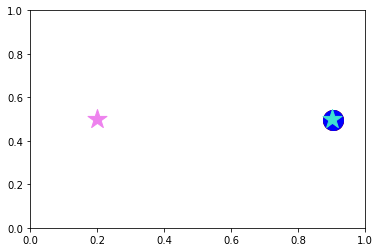

R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet


In [101]:
x = R1.betax
y = R1.betay
#plt.plot(x,y, 'o', c = 'black');
plt.scatter(x,y, s = 400, c = 'black')

x = R2.betax
y = R2.betay
plt.scatter(x, y, s = 400, c = 'red')

x = R3.betax
y = R3.betay
plt.scatter(x, y, s = 400, c = 'blue')

x = T.x
y = T.y
plt.scatter(x, y, s = 400, marker = '*', c = 'turquoise')

x = T2.x
y = T2.y
plt.scatter(x, y, s = 400, marker = '*', c = 'violet')


plt.axis([0, 1, 0, 1])
plt.show() 
print('R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet')

SOS shuffle

In [102]:
# threshold for initial reward
# random fluctuations

if (R1.delta <= 0.4) and (R2.delta <= 0.4) and (R3.delta <= 0.4):
    print("SOS")
    # R1
    R1.alphax = round(np.random.uniform(0,0.9), 3)
    R1.betax = round(1 - R1.alphax, 3)
    print("the new x-positions for R1 are: ", R1.alphax, R1.betax)
    R1.alphay = round(np.random.uniform(0,0.9), 3)
    R1.betay = round(1 - R1.alphay, 3)
    print("the new y-positions for R1 are: ", R1.alphay, R1.betay)
    # R2
    R2.alphax = round(np.random.uniform(0,0.9), 3)
    R2.betax = round(1 - R2.alphax, 3)
    print("the new x-positions for R2 are: ", R2.alphax, R1.betax)
    R2.alphay = round(np.random.uniform(0,0.9), 3)
    R2.betay = round(1 - R2.alphay, 3)
    print("the new y-positions for R2 are: ", R2.alphay, R1.betay)
    # R3
    R3.alphax = round(np.random.uniform(0,0.9), 3)
    R3.betax = round(1 - R3.alphax, 3)
    print("the new x-positions for R3 are: ", R3.alphax, R1.betax)
    R3.alphay = round(np.random.uniform(0,0.9), 3)
    R3.betay = round(1 - R3.alphay, 3)
    print("the new y-positions for R3 are: ", R3.alphay, R1.betay)
    
R1.delta = reward(T2, R1.betax, R1.betay)
R1.gamma = 1 - R1.delta
R2.delta = reward(T2, R2.betax, R2.betay)
R2.gamma = 1 - R2.delta
R3.delta = reward(T2, R3.betax, R3.betay)
R3.gamma = 1 - R3.delta
print(R1.delta, R2.delta, R3.delta)

SOS
the new x-positions for R1 are:  0.1 0.9
the new y-positions for R1 are:  0.489 0.511
the new x-positions for R2 are:  0.844 0.9
the new y-positions for R2 are:  0.145 0.511
the new x-positions for R3 are:  0.648 0.9
the new y-positions for R3 are:  0.702 0.511
0.3 0.64 0.75


graph

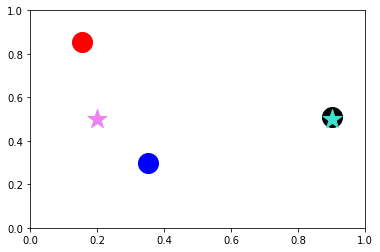

R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet


In [103]:
x = R1.betax
y = R1.betay
#plt.plot(x,y, 'o', c = 'black');
plt.scatter(x,y, s = 400, c = 'black')

x = R2.betax
y = R2.betay
plt.scatter(x, y, s = 400, c = 'red')

x = R3.betax
y = R3.betay
plt.scatter(x, y, s = 400, c = 'blue')


x = T.x
y = T.y
plt.scatter(x, y, s = 400, marker = '*', c = 'turquoise')

x = T2.x
y = T2.y
plt.scatter(x, y, s = 400, marker = '*', c = 'violet')

plt.axis([0, 1, 0, 1])
plt.show() 
print('R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet')

reach the most successful robot

In [104]:
if((R1.delta >= 0.8) or (R2.delta >= 0.8) or (R3.delta >= 0.8)):
    print('yuk')
    if (R1.delta > R2.delta and R1.delta > R3.delta):
        print('quokka')
        R2.betax = round(R1.betax + np.random.uniform(0,0.1), 3) # Here and later: 0.2. Change of January 23. Re-set as 0.1 on January 24
        R2.alphax = round(1 - R2.betax, 3)
        R2.betay = round(R1.betay + np.random.uniform(0,0.1), 3)
        R2.alphay = round(1 - R2.betay, 3)
        R3.betax = round(R1.betax + np.random.uniform(0,0.1), 3)
        R3.alphax = round(1 - R2.betax, 3)
        R3.betay = round(R1.betay + np.random.uniform(0,0.1), 3)
        R3.alphay = round(1 - R2.betay, 3)
    if (R2.delta > R1.delta and R2.delta > R3.delta):
        print('quagga')
        R1.betax = round(R2.betax + np.random.uniform(0,0.1), 3)
        R1.alphax = round(1 - R1.betax, 3)
        R1.betay = round(R2.betay + np.random.uniform(0,0.1), 3)
        R1.alphay = round(1 - R1.betay, 3)
        R3.betax = round(R2.betax + np.random.uniform(0,0.1), 3)
        R3.alphax = round(1 - R3.betax, 3)
        R3.betay = round(R2.betay + np.random.uniform(0,0.1), 3)
        R3.alphay = round(1 - R3.betay, 3)
    if (R3.delta > R1.delta and R3.delta > R2.delta):
        print('quark')
        R1.betax = round(R3.betax + np.random.uniform(0,0.1), 3)
        R1.alphax = round(1 - R1.betax, 3)
        R1.betay = round(R3.betay + np.random.uniform(0,0.1), 3)
        R1.alphay = round(1 - R1.betay, 3)
        R2.betax = round(R3.betax + np.random.uniform(0,0.1), 3)
        R2.alphax = round(1 - R2.betax, 3)
        R2.betay = round(R3.betay + np.random.uniform(0,0.1), 3)
        R2.alphay = round(1 - R2.betay, 3)
        
R1.delta = reward(T2, R1.betax, R1.betay)
print(R1.delta)

R2.delta = reward(T2, R2.betax, R2.betay)
print(R2.delta)

R3.delta = reward(T2, R3.betax, R3.betay)
print(R2.delta)

0.3
0.64
0.64


plot

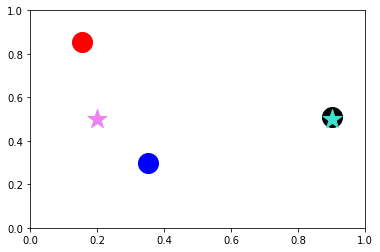

R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet


In [105]:
x = R1.betax
y = R1.betay
#plt.plot(x,y, 'o', c = 'black');
plt.scatter(x,y, s = 400, c = 'black')

x = R2.betax
y = R2.betay
plt.scatter(x, y, s = 400, c = 'red')

x = R3.betax
y = R3.betay
plt.scatter(x, y, s = 400, c = 'blue')

x = T.x
y = T.y
plt.scatter(x, y, s = 400, marker = '*', c = 'turquoise')

x = T2.x
y = T2.y
plt.scatter(x, y, s = 400, marker = '*', c = 'violet')

plt.axis([0, 1, 0, 1])
plt.show() 
print('R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet')

again SOS reshuffle

In [106]:
# Another round of SOS re-shuffle

# threshold for initial reward
# random fluctuations

if (R1.delta <= 0.4) and (R2.delta <= 0.4) and (R3.delta <= 0.4):
    print("SOS")
    # R1
    R1.alphax = round(np.random.uniform(0,0.9), 3)
    R1.betax = round(1 - R1.alphax, 3)
    print("the new x-positions for R1 are: ", R1.alphax, R1.betax)
    R1.alphay = round(np.random.uniform(0,0.9), 3)
    R1.betay = round(1 - R1.alphay, 3)
    print("the new y-positions for R1 are: ", R1.alphay, R1.betay)
    # R2
    R2.alphax = round(np.random.uniform(0,0.9), 3)
    R2.betax = round(1 - R2.alphax, 3)
    print("the new x-positions for R2 are: ", R2.alphax, R1.betax)
    R2.alphay = round(np.random.uniform(0,0.9), 3)
    R2.betay = round(1 - R2.alphay, 3)
    print("the new y-positions for R2 are: ", R2.alphay, R1.betay)
    # R3
    R3.alphax = round(np.random.uniform(0,0.9), 3)
    R3.betax = round(1 - R3.alphax, 3)
    print("the new x-positions for R3 are: ", R3.alphax, R1.betax)
    R3.alphay = round(np.random.uniform(0,0.9), 3)
    R3.betay = round(1 - R3.alphay, 3)
    print("the new y-positions for R3 are: ", R3.alphay, R1.betay)
    
R1.delta = reward(T2, R1.betax, R1.betay)
R1.gamma = 1 - R1.delta
R2.delta = reward(T2, R2.betax, R2.betay)
R2.gamma = 1 - R2.delta
R3.delta = reward(T2, R3.betax, R3.betay)
R3.gamma = 1 - R3.delta
print(R1.delta, R2.delta, R3.delta)

0.3 0.64 0.75


graph

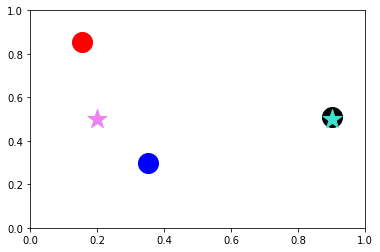

R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet


In [107]:
x = R1.betax
y = R1.betay
#plt.plot(x,y, 'o', c = 'black');
plt.scatter(x,y, s = 400, c = 'black')

x = R2.betax
y = R2.betay
plt.scatter(x, y, s = 400, c = 'red')

x = R3.betax
y = R3.betay
plt.scatter(x, y, s = 400, c = 'blue')

x = T.x
y = T.y
plt.scatter(x, y, s = 400, marker = '*', c = 'turquoise')

x = T2.x
y = T2.y
plt.scatter(x, y, s = 400, marker = '*', c = 'violet')

plt.axis([0, 1, 0, 1])
plt.show() 
print('R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet')

In [108]:
q = QuantumRegister(5, 'q'); # qubits # changed to 9, formerly 15
m2 = ClassicalRegister(1, 'c1'); # classical bits (separated is better)
m3 = ClassicalRegister(1, 'c2');
m4 = ClassicalRegister(1, 'c3');

qc4 = QuantumCircuit(q, m2, m3, m4); # to get back to the nest

Gate! SECOND GATE

In [109]:
if (R1.delta > R2.delta) and (R1.delta > R3.delta):
    if (R1.alphax < 0.3): # I have to customize state vectors according to precise probabilities!
        qc4.x(q[0])        # just using the NOT gate as a test
    if (R1.alphax == 0.5): # I have to customize state vectors according to precise probabilities!
        qc4.h(q[0])
    if (R1.alphax >= 0.3) and (R2.alphax < 0.5):
        print('jungle!')
        qc4.ry(1.9106332, q[0])
    if (R1.alphax >= 0.6) and (R2.alphax < 0.7):
        print('ocean!')
        qc4.ry(1.2309594, q[0])
    if (R1.alphay <= 0.2): # else: the qubit sticks with the default value '0'
        qc4.x(q[1])
    if (R1.alphay == 0.5): # I have to customize state vectors according to precise probabilities!
        qc4.h(q[1])
    if (R1.alphay >= 0.3) and (R2.alphay < 0.5):
        print('jungle!')
        qc4.ry(1.9106332, q[1])
    if (R1.alphay >= 0.6) and (R2.alphay < 0.7):
        print('ocean!')
        qc4.ry(1.2309594, q[1])
    if (R1.delta == 0.5):
        qc4.h(q[2])
    if (R1.delta == 0.6):
        qc4.h(q[2])
    if (R1.delta >= 0.7):
        qc4.x(q[2])
    if (R1.gamma >= 0.3) and (R2.gamma < 0.5):
        print('jungle!')
        qc4.ry(1.9106332, q[2])
    if (R1.gamma >= 0.6) and (R2.gamma < 0.7):
        print('ocean!')
        qc4.ry(1.2309594, q[2])
# elif (R1.delta > R2.delta) and (R1.delta > R3.delta): # February 13: NO!!!!
elif (R2.delta > R1.delta) and (R2.delta > R3.delta):
    print('dog')
    if (R2.alphax < 0.3): # I have to customize state vectors according to precise probabilities!
        qc4.x(q[0])        # just using the NOT gate as a test
    if (R2.alphax == 0.5): # I have to customize state vectors according to precise probabilities!
        qc4.h(q[0])
    if (R2.alphax >= 0.3) and (R1.alphax < 0.5):
        print('jungle!')
        qc4.ry(1.9106332, q[0])
    if (R2.alphax >= 0.6) and (R1.alphax < 0.7):
        print('ocean!')
        qc4.ry(1.2309594, q[0])
    if (R2.alphay <= 0.2): # else: the qubit sticks with the default value '0'
        qc4.x(q[1])
    if (R2.alphay == 0.5): # I have to customize state vectors according to precise probabilities!
        qc4.h(q[1])
    if (R2.alphay >= 0.3) and (R1.alphay < 0.5):
        print('jungle!')
        qc4.ry(1.9106332, q[1])
    if (R2.alphay >= 0.6) and (R1.alphay < 0.7):
        print('ocean!')
        qc4.ry(1.2309594, q[1])
    if (R2.delta == 0.5):
        qc4.h(q[2])
    if (R2.delta == 0.6):
        qc4.h(q[2])
    if (R2.delta >= 0.7):
        qc4.x(q[2])
    if (R2.gamma >= 0.3) and (R1.gamma < 0.5):
        print('jungle!')
        qc4.ry(1.9106332, q[2])
    if (R2.gamma >= 0.6) and (R1.gamma < 0.7):
        print('ocean!')
        qc4.ry(1.2309594, q[2])
else:
    print('cat') # I made some tests to check the IF conditions
    if (R3.alphax < 0.3): 
        qc4.x(q[0])
    if (R3.alphax == 0.5):
        qc4.h(q[0])
    if (R3.alphax >= 0.3) and (R3.alphax < 0.5):
        print('jungle!')
        qc4.ry(1.9106332, q[0])
    if (R3.alphax >= 0.6) and (R3.alphax < 0.7):
        print('ocean!')
        qc4.ry(1.2309594, q[0])
    if (R3.alphay < 0.3):
        qc4.x(q[1])
    if (R3.alphay == 0.5):
        qc4.h(q[1])
    if (R3.alphay >= 0.3) and (R3.alphay < 0.5):
        print('jungle!')
        qc4.ry(1.9106332, q[1])
    if (R3.alphay >= 0.6) and (R3.alphay < 0.7):
        print('ocean!')
        qc4.ry(1.2309594, q[1])
    if (R3.delta == 0.5):
        qc4.h(q[2])
    if (R3.delta == 0.6):
        qc4.h(q[2])
    if (R3.delta >= 0.7):
        qc4.x(q[2])
    if (R3.gamma >= 0.3) and (R3.gamma < 0.5):
        print('jungle!')
        qc4.ry(1.9106332, q[2])
    if (R3.gamma >= 0.6) and (R3.gamma < 0.7):
        print('ocean!')
        qc4.ry(1.2309594, q[2])

cat
ocean!


the core code

CircuitComposer(circuit=<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fb40827a1f0>, editable=Fals…

{'0 1 1': 336, '0 0 1': 688}
0 0 1
[]
['0 0 1', '0 0 1', '0 0 1', '0 0 1', '0 1 1', '0 0 1', '0 1 1', '0 0 1', '0 0 1', '0 1 1']


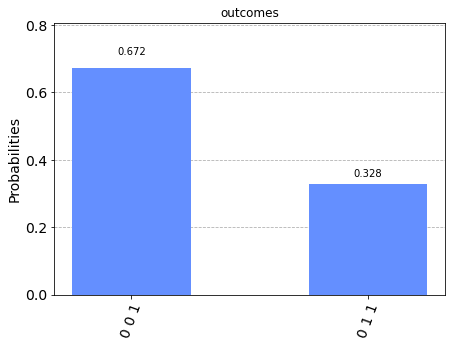

In [110]:
# this is the core code, and it is unchanged across time

qc4.barrier(q)
qc4.ccx(q[0],q[1],q[3])
qc4.ccx(q[0],q[1],q[4])

qc4.reset(q[3]);
qc4.reset(q[4]);

qc4.ccx(q[0],q[2],q[3])
qc4.ccx(q[1],q[2],q[4])

qc4.x(q[2])

qc4.ch(q[2],q[3])
qc4.ch(q[2],q[4])

qc4.x(q[2])

qc4.barrier(q)

# perform measurements and store them in classical bits

qc4.measure(q[2],m2[0])
qc4.measure(q[3],m3[0])
qc4.measure(q[4],m4[0])

# visualization of the ciruit

draw_circuit(qc4)

# definition of quantum simulator

simulator = Aer.get_backend('qasm_simulator') # statevector_simulator # aer_simulator # qasm_simulator
qc4 = transpile(qc4, simulator)
cc = collections.Counter()

# Run and get counts
result = simulator.run(qc4, shots=1024).result()
counts = result.get_counts(qc4)
counts2 = counts.most_frequent() # does not work if multiple states have the same counts
# decide something if multiple states have the same count --> e.g., ``choose the first''
counts3 = cc.most_common(2)
print(counts)
print(counts2)
print(counts3)
result = simulator.run(qc4, shots=10, memory=True).result()
memory = result.get_memory(qc4)
print(memory)
plot_histogram(counts, title='outcomes')
# TAKE the TWO more present outcomes

In [93]:
# I should create new arrays 1, 2, but here I keep the same names for the sake of simplicity.
# The arrays are automatically rewritten...

My intervention is needed here, where indicated:

In [111]:
print(counts2) # order: R3, R2, R1. Add some uncertainty?
# export as an array
str = counts2
arr1 = str.split(' ') # to split the string and avoid empty spaces as array elements
print(arr1)
weight1 = 688 # AT HAND ONLY FOR NOW

arr2 = ['0','1','1'] # 111 # 011
print(arr2)
weight2 = 336
# BY HAND ONLY FOR NOW


# an attempt, not so good, to automatize this passage:

print(memory)

data = Counter(memory)
data.most_common()   # Returns all unique items and their counts
data.most_common(3) 

print(data.most_common())
print(data.most_common(1))
arrx1 = data.most_common(2)[0]
print(arrx1)
arrx2 = data.most_common(2)[1]
print(arrx2)

0 0 1
['0', '0', '1']
['0', '1', '1']
['0 0 1', '0 0 1', '0 0 1', '0 0 1', '0 1 1', '0 0 1', '0 1 1', '0 0 1', '0 0 1', '0 1 1']
[('0 0 1', 7), ('0 1 1', 3)]
[('0 0 1', 7)]
('0 0 1', 7)
('0 1 1', 3)


check

In [112]:
arr1, arr2

(['0', '0', '1'], ['0', '1', '1'])

reset position of $R_1$

In [113]:
if (R1.delta > R2.delta) and (R1.delta > R3.delta):
    # if R1 didn't enter the gate, keep its position
    R1.alphax = R1.alphax
    R1.betax = R1.betax
    R1.alphay = R1.alphay
    R1.betay = R1.betay
else:
    # same outcome = 1 # January 23
    # x part
    
    
    # change [0] --> [1] and vice versa, January 28
    if (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight1 - weight2) > 50 and (weight1 - weight2) < 200): # no ABS here # change of January 23
        print("bla")
        R1.alphax = 0.3   
        R1.betax = 0.7   
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight2 - weight1) > 50 and (weight1 - weight2) < 200): # no ABS here # change of January 23
        print("gulp")
        R1.alphax = 0.7   
        R1.betax = 0.3    
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): # change of January 23
        print("stra-gulp")
        R1.alphax = 0.5 # change temporarily made on January 24: random generator rather than 0.5  
        R1.betax = 0.5 # same as above
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight2 - weight1) > 800): # no abs # change of January 23
        print("thunderstorm!")
        R1.alphax = 0 
        R1.betax = 1
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
        print("avalanche!")
        R1.alphax = 0.1 
        R1.betax = 0.9
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
        print("earthquake!")
        R1.alphax = 0.9
        R1.betax = 0.1
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 23
        print("avalanche bis!")
        R1.alphax = 0.1 # the same also in this case
        R1.betax = 0.9 # the same also in this case
    # same = outcome 0  # January 23
    elif (arr1[1] == arr2[1]) and (arr1[1] == '0') and ((weight1 - weight2) > 50): # no ABS here # change of January 23
        print("bla 2")
        R1.alphax = 0.7  # the opposite??   
        R1.betax = 0.3  # the opposite??   
    elif (arr1[1] == arr2[1]) and (arr1[1] == '0') and ((weight2 - weight1) > 50): # no ABS here # change of January 23
        print("gulp 2")
        R1.alphax = 0.3  # the opposite??   
        R1.betax = 0.7  # the opposite??    
    elif (arr1[1] == arr2[1]) and (arr1[1] == '0') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): # change of January 23
        print("stra-gulp 2")
        R1.alphax = 0.5 # change temporarily made on January 24: random generator rather than 0.5 #1   # the opposite
        R1.betax = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.5 #0  # the opposite 
    # different outcomes
    elif arr1[1] != arr2[1]:  # January 23
        print("blue")
        if (arr1[1] != arr2[1]) and (weight1 == weight2 or np.absolute(weight1 - weight2) < 50):
            print("google 1")
            R1.alphax = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.5
            R1.betax = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.5
        if (arr1[1] == '1' and arr2[1] == '0') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): 
            # include the case of a very small difference!
            print("uffdah")
            R1.alphax = 0.5
            R1.betax = 0.5
        if (arr1[1] == '1' and arr2[1] == '0'):
            if (weight1 - weight2 >= 50 and weight1 - weight2 <= 200):
                print("abc")
                R1.alphax = 0.3
                R1.betax = 0.7
            if (weight2 - weight1 >= 50 and weight1 - weight2 <= 200):
                print("bca")
                R1.alphax = 0.7
                R1.betax = 0.3
            if ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 23
                print("news")
                R1.alphax = 0.2 #
                R1.betax = 0.8 # 
            if ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
                print("idea")
                R1.alphax = 0.8 #
                R1.betax = 0.2 #
        if (arr1[1] == '0') and (arr2[1] == '1'):
            if (weight1 - weight2 >= 50 and weight1 - weight2 <= 200):
                print("bac")
                R1.alphax = 0.7
                R1.betax = 0.3
            if (weight2 - weight1 >= 50 and weight1 - weight2 <= 200):
                print("cba")
                R1.alphax = 0.3
                R1.betax = 0.7
            if ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 26
                print("brain")
                R1.alphax = 0.7 # 0.9
                R1.betax = 0.3 # 0.1
            if ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 26
                print("hand")
                R1.alphax = 0.3 # 0.1
                R1.betax = 0.7 # 0.9
    # y part
    
    # change of January 26
    
    if (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight1 - weight2) > 50 and (weight1 - weight2) < 200): # no ABS here # change of January 23
        print("bla")
        R1.alphay = 0.3   
        R1.betay = 0.7   
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight2 - weight1) > 50 and (weight1 - weight2) < 200): # no ABS here # change of January 23
        print("gulp")
        R1.alphay = 0.7   
        R1.betay = 0.3    
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): # change of January 23
        print("stra-gulp")
        R1.alphay = 0.5 # change temporarily made on January 24: random generator rather than 0.5  
        R1.betay = 0.5 # same as above
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight2 - weight1) > 800): # no abs # change of January 23
        print("thunderstorm!")
        R1.alphay = 0 
        R1.betay = 1
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
        print("avalanche!")
        R1.alphay = 0.1 
        R1.betay = 0.9
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
        print("earthquake!")
        R1.alphay = 0.9
        R1.betay = 0.1
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 23
        print("avalanche bis!")
        R1.alphay = 0.1 # the same also in this case
        R1.betay = 0.9 # the same also in this case
    # same = outcome 0  # January 23
    elif (arr1[0] == arr2[0]) and (arr1[0] == '0') and ((weight1 - weight2) > 50): # no ABS here # change of January 23
        print("bla 2")
        R1.alphay = 0.7  # the opposite??   
        R1.betay = 0.3  # the opposite??   
    elif (arr1[0] == arr2[0]) and (arr1[0] == '0') and ((weight2 - weight1) > 50): # no ABS here # change of January 23
        print("gulp 2")
        R1.alphay = 0.3  # the opposite??   
        R1.betay = 0.7  # the opposite??    
    elif (arr1[0] == arr2[0]) and (arr1[0] == '0') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): # change of January 23
        print("stra-gulp 2")
        R1.alphay = 0.5 # change temporarily made on January 24: random generator rather than 0.5 #1   # the opposite
        R1.betay = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.5 #0  # the opposite 
    # different outcomes
    elif arr1[0] != arr2[0]:  # January 23
        print("blue")
        if (arr1[0] != arr2[0]) and (weight1 == weight2 or np.absolute(weight1 - weight2) < 50):
            print("google 1")
            R1.alphay = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.5
            R1.betay = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.5
        if (arr1[0] == '1' and arr2[0] == '0') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): 
            # include the case of a very small difference!
            print("uffdah")
            R1.alphay = 0.5
            R1.betay = 0.5
        if (arr1[0] == '1' and arr2[0] == '0'):
            if (weight1 - weight2 >= 50 and weight1 - weight2 <= 200):
                print("abc")
                R1.alphay = 0.3
                R1.betay = 0.7
            if (weight2 - weight1 >= 50 and weight1 - weight2 <= 200):
                print("bca")
                R1.alphay = 0.7
                R1.betay = 0.3
            if ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 23
                print("news")
                R1.alphay = 0.2 #
                R1.betay = 0.8 #
            if ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
                print("idea")
                R1.alphay = 0.8 #
                R1.betay = 0.2 #
        if (arr1[0] == '0') and (arr2[0] == '1'):
            if (weight1 - weight2 >= 50 and weight1 - weight2 <= 200):
                print("bac")
                R1.alphay = 0.7
                R1.betay = 0.3
            if (weight2 - weight1 >= 50 and weight1 - weight2 <= 200):
                print("cba")
                R1.alphay = 0.3
                R1.betay = 0.7
            if ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 26
                print("brain")
                R1.alphay = 0.7 # 0.9
                R1.betay = 0.3 # 0.1
            if ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 26
                print("hand")
                R1.alphay = 0.3 # 0.1
                R1.betay = 0.7 # 0.9

blue
brain
bla 2


reset position of $R_2$

In [114]:
if (R2.delta > R1.delta) and (R2.delta > R3.delta):
    # if R2 didn't entered the gate, keep its position
    R2.alphax = R2.alphax
    R2.betax = R2.betax
    R2.alphay = R2.alphay
    R2.betay = R2.betay
else:
    # same outcome = 1 # January 23
    # x part
    if (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight1 - weight2) > 50 and (weight1 - weight2) < 200): # no ABS here # change of January 23
        print("bla")
        R2.alphax = 0.3   
        R2.betax = 0.7   
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight2 - weight1) > 50 and (weight1 - weight2) < 200): # no ABS here # change of January 23
        print("gulp")
        R2.alphax = 0.7   
        R2.betax = 0.3    
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): # change of January 23
        print("stra-gulp")
        R2.alphax = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.50.5 # xx   
        R2.betax = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.50.5 # xx
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight2 - weight1) > 800): # no abs # change of January 23
        print("thunderstorm!")
        R2.alphax = 0 
        R2.betax = 1
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
        print("avalanche!")
        R2.alphax = 0.1 
        R2.betax = 0.9
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
        print("earthquake!")
        R2.alphax = 0.9
        R2.betax = 0.1
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 23
        print("avalanche bis!")
        R2.alphax = 0.1 # the same also in this case
        R2.betax = 0.9 # the same also in this case
    # same = outcome 0  # January 23
    elif (arr1[1] == arr2[1]) and (arr1[1] == '0') and ((weight1 - weight2) > 50): # no ABS here # change of January 23
        print("bla 2")
        R2.alphax = 0.7  # the opposite??   
        R2.betax = 0.3  # the opposite??   
    elif (arr1[1] == arr2[1]) and (arr1[1] == '0') and ((weight2 - weight1) > 50): # no ABS here # change of January 23
        print("gulp 2")
        R2.alphax = 0.3  # the opposite??   
        R2.betax = 0.7  # the opposite??    
    elif (arr1[1] == arr2[1]) and (arr1[1] == '0') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): # change of January 23
        print("stra-gulp 2")
        R2.alphax = 0.5 #1   # the opposite
        R2.betax = 0.5 #0  # the opposite 
    # different outcomes
    elif arr1[1] != arr2[1]:  # January 23
        print("blue")
        if (arr1[1] != arr2[1]) and (weight1 == weight2 or np.absolute(weight1 - weight2) < 50):
            print("google 1")
            R2.alphax = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.50.5
            R2.betax = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.50.5
        if (arr1[1] == '1' and arr2[1] == '0') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): 
            # include the case of a very small difference!
            print("uffdah")
            R2.alphax = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.50.5
            R2.betax = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.50.5
        if (arr1[1] == '1' and arr2[1] == '0'):
            print("gasp")
            if (weight1 - weight2 >= 50 and weight1 - weight2 <= 200):
                print("abc")
                R2.alphax = 0.3
                R2.betax = 0.7
            if (weight2 - weight1 >= 50 and weight1 - weight2 <= 200):
                print("bca")
                R2.alphax = 0.7
                R2.betax = 0.3
            if ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 23
                print("news")
                R2.alphax = 0.3 # 0. 126 January
                R2.betax = 0.7 # 0.9
            if ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
                print("idea")
                R2.alphax = 0.7 # 0.9
                R2.betax = 0.3 # 0.1
        if (arr1[1] == '0') and (arr2[1] == '1'):
            print("sigh")
            if (weight1 - weight2 >= 50 and weight1 - weight2 <= 200):
                print("bac")
                R2.alphax = 0.7
                R2.betax = 0.3
            if (weight2 - weight1 >= 50 and weight1 - weight2 <= 200):
                print("cba")
                R2.alphax = 0.3
                R2.betax = 0.7
            
   # y part 
    # change of January 26
    
    # to be modified: R1 to R2
    
    if (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight1 - weight2) > 50 and (weight1 - weight2) < 200): # no ABS here # change of January 23
        print("bla")
        R2.alphay = 0.3   
        R2.betay = 0.7   
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight2 - weight1) > 50 and (weight1 - weight2) < 200): # no ABS here # change of January 23
        print("gulp")
        R2.alphay = 0.7   
        R2.betay = 0.3    
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): # change of January 23
        print("stra-gulp")
        R2.alphay = 0.5 # change temporarily made on January 24: random generator rather than 0.5  
        R2.betay = 0.5 # same as above
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight2 - weight1) > 800): # no abs # change of January 23
        print("thunderstorm!")
        R2.alphay = 0 
        R2.betay = 1
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
        print("avalanche!")
        R2.alphay = 0.1 
        R2.betay = 0.9
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
        print("earthquake!")
        R2.alphay = 0.9
        R2.betay = 0.1
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 23
        print("avalanche bis!")
        R2.alphay = 0.1 # the same also in this case
        R2.betay = 0.9 # the same also in this case
    # same = outcome 0  # January 23
    elif (arr1[0] == arr2[0]) and (arr1[0] == '0') and ((weight1 - weight2) > 50): # no ABS here # change of January 23
        print("bla 2")
        R2.alphay = 0.7  # the opposite??   
        R2.betay = 0.3  # the opposite??   
    elif (arr1[0] == arr2[0]) and (arr1[0] == '0') and ((weight2 - weight1) > 50): # no ABS here # change of January 23
        print("gulp 2")
        R2.alphay = 0.3  # the opposite??   
        R2.betay = 0.7  # the opposite??    
    elif (arr1[0] == arr2[0]) and (arr1[0] == '0') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): # change of January 23
        print("stra-gulp 2")
        R2.alphay = 0.5 # change temporarily made on January 24: random generator rather than 0.5 #1   # the opposite
        R2.betay = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.5 #0  # the opposite 
    # different outcomes
    elif arr1[0] != arr2[0]:  # January 23
        print("blue")
        if (arr1[0] != arr2[0]) and (weight1 == weight2 or np.absolute(weight1 - weight2) < 50):
            print("google 1")
            R2.alphay = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.5
            R2.betay = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.5
        if (arr1[0] == '1' and arr2[0] == '0') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): 
            # include the case of a very small difference!
            print("uffdah")
            R2.alphay = 0.5
            R2.betay = 0.5
        if (arr1[0] == '1' and arr2[0] == '0'):
            if (weight1 - weight2 >= 50 and weight1 - weight2 <= 200):
                print("abc")
                R2.alphay = 0.3
                R2.betay = 0.7
            if (weight2 - weight1 >= 50 and weight1 - weight2 <= 200):
                print("bca")
                R2.alphay = 0.7
                R2.betay = 0.3
            if ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 23
                print("news")
                R2.alphay = 0.3 #
                R2.betay = 0.7 #
            if ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
                print("idea")
                R2.alphay = 0.7 #
                R2.betay = 0.3 #
        if (arr1[0] == '0') and (arr2[0] == '1'):
            if (weight1 - weight2 >= 50 and weight1 - weight2 <= 200):
                print("bac")
                R2.alphay = 0.7
                R2.betay = 0.3
            if (weight2 - weight1 >= 50 and weight1 - weight2 <= 200):
                print("cba")
                R2.alphay = 0.3
                R2.betay = 0.7
            if ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 26
                print("brain")
                R2.alphay = 0.7 # 0.9
                R2.betay = 0.3 # 0.1
            if ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 26
                print("hand")
                R2.alphay = 0.3 # 0.1
                R2.betay = 0.7 # 0.9

blue
sigh
bla 2


reset position of $R_3$

In [115]:
if (R2.delta > R1.delta) and (R2.delta > R3.delta):
    # if R2 didn't entered the gate, keep its position
    R2.alphax = R2.alphax
    R2.betax = R2.betax
    R2.alphay = R2.alphay
    R2.betay = R2.betay
else:
    # same outcome = 1 # January 23
    # x part
    if (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight1 - weight2) > 50 and (weight1 - weight2) < 200): # no ABS here # change of January 23
        print("bla")
        R2.alphax = 0.3   
        R2.betax = 0.7   
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight2 - weight1) > 50 and (weight1 - weight2) < 200): # no ABS here # change of January 23
        print("gulp")
        R2.alphax = 0.7   
        R2.betax = 0.3    
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): # change of January 23
        print("stra-gulp")
        R2.alphax = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.50.5 # xx   
        R2.betax = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.50.5 # xx
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight2 - weight1) > 800): # no abs # change of January 23
        print("thunderstorm!")
        R2.alphax = 0 
        R2.betax = 1
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
        print("avalanche!")
        R2.alphax = 0.1 
        R2.betax = 0.9
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
        print("earthquake!")
        R2.alphax = 0.8
        R2.betax = 0.2
    elif (arr1[1] == arr2[1]) and (arr1[1] == '1') and ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 23
        print("avalanche bis!")
        R2.alphax = 0.2 # the same also in this case
        R2.betax = 0.8 # the same also in this case # January 26; this or 0.3, 0.7
    # same = outcome 0  # January 23
    elif (arr1[1] == arr2[1]) and (arr1[1] == '0') and ((weight1 - weight2) > 50): # no ABS here # change of January 23
        print("bla 2")
        R2.alphax = 0.7  # the opposite??   
        R2.betax = 0.3  # the opposite??   
    elif (arr1[1] == arr2[1]) and (arr1[1] == '0') and ((weight2 - weight1) > 50): # no ABS here # change of January 23
        print("gulp 2")
        R2.alphax = 0.3  # the opposite??   
        R2.betax = 0.7  # the opposite??    
    elif (arr1[1] == arr2[1]) and (arr1[1] == '0') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): # change of January 23
        print("stra-gulp 2")
        R2.alphax = 0.5 #1   # the opposite
        R2.betax = 0.5 #0  # the opposite 
    # different outcomes
    elif arr1[1] != arr2[1]:  # January 23
        print("blue")
        if (arr1[1] != arr2[1]) and (weight1 == weight2 or np.absolute(weight1 - weight2) < 50):
            print("google 1")
            R2.alphax = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.50.5
            R2.betax = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.50.5
        if (arr1[1] == '1' and arr2[1] == '0') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): 
            # include the case of a very small difference!
            print("uffdah")
            R2.alphax = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.50.5
            R2.betax = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.50.5
        if (arr1[1] == '1' and arr2[1] == '0'):
            print("gasp")
            if (weight1 - weight2 >= 50 and weight1 - weight2 <= 200):
                print("abc")
                R2.alphax = 0.3
                R2.betax = 0.7
            if (weight2 - weight1 >= 50 and weight1 - weight2 <= 200):
                print("bca")
                R2.alphax = 0.7
                R2.betax = 0.3
            if ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 23
                print("news")
                R2.alphax = 0.3 #
                R2.betax = 0.7 #
            if ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
                print("idea")
                R2.alphax = 0.7 #
                R2.betax = 0.3 #
        if (arr1[1] == '0') and (arr2[1] == '1'):
            print("sigh")
            if (weight1 - weight2 >= 50 and weight1 - weight2 <= 200):
                print("bac")
                R2.alphax = 0.7
                R2.betax = 0.3
            if (weight2 - weight1 >= 50 and weight1 - weight2 <= 200):
                print("cba")
                R2.alphax = 0.3
                R2.betax = 0.7
            
   # y part 
    # change of January 26
    
    # to be modified: R1 to R2
    
    if (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight1 - weight2) > 50 and (weight1 - weight2) < 200): # no ABS here # change of January 23
        print("bla")
        R2.alphay = 0.3   
        R2.betay = 0.7   
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight2 - weight1) > 50 and (weight1 - weight2) < 200): # no ABS here # change of January 23
        print("gulp")
        R2.alphay = 0.7   
        R2.betay = 0.3    
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): # change of January 23
        print("stra-gulp")
        R2.alphay = 0.5 # change temporarily made on January 24: random generator rather than 0.5  
        R2.betay = 0.5 # same as above
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight2 - weight1) > 800): # no abs # change of January 23
        print("thunderstorm!")
        R2.alphay = 0 
        R2.betay = 1
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
        print("avalanche!")
        R2.alphay = 0.1 
        R2.betay = 0.9
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
        print("earthquake!")
        R2.alphay = 0.9
        R2.betay = 0.1
    elif (arr1[0] == arr2[0]) and (arr1[0] == '1') and ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 23
        print("avalanche bis!")
        R2.alphay = 0.1 # the same also in this case
        R2.betay = 0.9 # the same also in this case
    # same = outcome 0  # January 23
    elif (arr1[0] == arr2[0]) and (arr1[0] == '0') and ((weight1 - weight2) > 50): # no ABS here # change of January 23
        print("bla 2")
        R2.alphay = 0.7  # the opposite??   
        R2.betay = 0.3  # the opposite??   
    elif (arr1[0] == arr2[0]) and (arr1[0] == '0') and ((weight2 - weight1) > 50): # no ABS here # change of January 23
        print("gulp 2")
        R2.alphay = 0.3  # the opposite??   
        R2.betay = 0.7  # the opposite??    
    elif (arr1[0] == arr2[0]) and (arr1[0] == '0') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): # change of January 23
        print("stra-gulp 2")
        R2.alphay = 0.5 # change temporarily made on January 24: random generator rather than 0.5 #1   # the opposite
        R2.betay = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.5 #0  # the opposite 
    # different outcomes
    elif arr1[0] != arr2[0]:  # January 23
        print("blue")
        if (arr1[0] != arr2[0]) and (weight1 == weight2 or np.absolute(weight1 - weight2) < 50):
            print("google 1")
            R2.alphay = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.5
            R2.betay = 0.5 # change temporarily made on January 24: random generator rather than 0.5 0.5
        if (arr1[0] == '1' and arr2[0] == '0') and (weight1 == weight2 or np.absolute(weight1 - weight2) <= 50): 
            # include the case of a very small difference!
            print("uffdah")
            R2.alphay = 0.5
            R2.betay = 0.5
        if (arr1[0] == '1' and arr2[0] == '0'):
            if (weight1 - weight2 >= 50 and weight1 - weight2 <= 200):
                print("abc")
                R2.alphay = 0.3
                R2.betay = 0.7
            if (weight2 - weight1 >= 50 and weight1 - weight2 <= 200):
                print("bca")
                R2.alphay = 0.7
                R2.betay = 0.3
            if ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 23
                print("news")
                R2.alphay = 0.3 #
                R2.betay = 0.7 #
            if ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 23
                print("idea")
                R2.alphay = 0.7 #
                R2.betay = 0.3 #
        if (arr1[0] == '0') and (arr2[0] == '1'):
            if (weight1 - weight2 >= 50 and weight1 - weight2 <= 200):
                print("bac")
                R2.alphay = 0.7
                R2.betay = 0.3
            if (weight2 - weight1 >= 50 and weight1 - weight2 <= 200):
                print("cba")
                R2.alphay = 0.3
                R2.betay = 0.7
            if ((weight1 - weight2) > 200 and (weight1 - weight2) < 800): # no abs # change of January 26
                print("brain")
                R2.alphay = 0.7 # 0.9
                R2.betay = 0.3 # 0.1
            if ((weight2 - weight1) > 200 and (weight2 - weight1) < 800): # no abs # change of January 26
                print("hand")
                R2.alphay = 0.3 # 0.1
                R2.betay = 0.7 # 0.9

blue
sigh
bla 2


graph

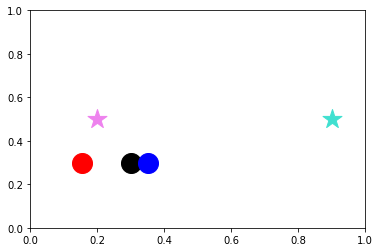

R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet


In [116]:
x = R1.betax
y = R1.betay
#plt.plot(x,y, 'o', c = 'black');
plt.scatter(x,y, s = 400, c = 'black')

x = R2.betax
y = R2.betay
plt.scatter(x, y, s = 400, c = 'red')

x = R3.betax
y = R3.betay
plt.scatter(x, y, s = 400, c = 'blue')

x = T.x
y = T.y
plt.scatter(x, y, s = 400, marker = '*', c = 'turquoise')

x = T2.x
y = T2.y
plt.scatter(x, y, s = 400, marker = '*', c = 'violet')

plt.axis([0, 1, 0, 1])
plt.show() 
print('R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet')

In [117]:
# former rewards

R1.delta, R2.delta, R3.delta

(0.3, 0.64, 0.75)

In [118]:
# new rewards

R1.delta = reward(T2, R1.betax, R1.betay)
print(R1.delta)

R2.delta = reward(T2, R2.betax, R2.betay)
print(R2.delta)

R3.delta = reward(T2, R3.betax, R3.betay)
print(R3.delta)

0.78
0.8
0.75


reach the most successful robot

In [119]:
if((R1.delta >= 0.8) or (R2.delta >= 0.8) or (R3.delta >= 0.8)):
    print('yuk')
    if (R1.delta > R2.delta and R1.delta > R3.delta):
        print('quokka')
        R2.betax = round(R1.betax + np.random.uniform(0,0.1), 3)
        R2.alphax = round(1 - R2.betax, 3)
        R2.betay = round(R1.betay + np.random.uniform(0,0.1), 3)
        R2.alphay = round(1 - R2.betay, 3)
        R3.betax = round(R1.betax + np.random.uniform(0,0.1), 3)
        R3.alphax = round(1 - R2.betax, 3)
        R3.betay = round(R1.betay + np.random.uniform(0,0.1), 3)
        R3.alphay = round(1 - R2.betay, 3)
    if (R2.delta > R1.delta and R2.delta > R3.delta):
        print('quagga')
        R1.betax = round(R2.betax + np.random.uniform(0,0.1), 3)
        R1.alphax = round(1 - R1.betax, 3)
        R1.betay = round(R2.betay + np.random.uniform(0,0.1), 3)
        R1.alphay = round(1 - R1.betay, 3)
        R3.betax = round(R2.betax + np.random.uniform(0,0.1), 3)
        R3.alphax = round(1 - R3.betax, 3)
        R3.betay = round(R2.betay + np.random.uniform(0,0.1), 3)
        R3.alphay = round(1 - R3.betay, 3)
    if (R3.delta > R1.delta and R3.delta > R2.delta):
        print('quark')
        R1.betax = round(R3.betax + np.random.uniform(0,0.1), 3)
        R1.alphax = round(1 - R1.betax, 3)
        R1.betay = round(R3.betay + np.random.uniform(0,0.1), 3)
        R1.alphay = round(1 - R1.betay, 3)
        R2.betax = round(R3.betax + np.random.uniform(0,0.1), 3)
        R2.alphax = round(1 - R2.betax, 3)
        R2.betay = round(R3.betay + np.random.uniform(0,0.1), 3)
        R2.alphay = round(1 - R2.betay, 3)
        
R1.delta = reward(T2, R1.betax, R1.betay)
print(R2.delta)

R2.delta = reward(T2, R2.betax, R2.betay)
print(R2.delta)

R3.delta = reward(T2, R3.betax, R3.betay)
print(R3.delta)

yuk
quagga
0.8
0.8
0.83


plot

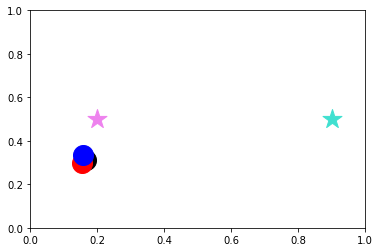

R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet


In [120]:
x = R1.betax
y = R1.betay
#plt.plot(x,y, 'o', c = 'black');
plt.scatter(x,y, s = 400, c = 'black')

x = R2.betax
y = R2.betay
plt.scatter(x, y, s = 400, c = 'red')

x = R3.betax
y = R3.betay
plt.scatter(x, y, s = 400, c = 'blue')

x = T.x
y = T.y
plt.scatter(x, y, s = 400, marker = '*', c = 'turquoise')

x = T2.x
y = T2.y
plt.scatter(x, y, s = 400, marker = '*', c = 'violet')

plt.axis([0, 1, 0, 1])
plt.show() 
print('R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet')

In [121]:
# Another round of SOS with a higher threshold. Added on January 28

# threshold for initial reward
# random fluctuations

if (R1.delta <= 0.6) and (R2.delta <= 0.6) and (R3.delta <= 0.6):
    print("SOS")
    # R1
    R1.alphax = round(np.random.uniform(0,0.9), 3)
    R1.betax = round(1 - R1.alphax, 3)
    print("the new x-positions for R1 are: ", R1.alphax, R1.betax)
    R1.alphay = round(np.random.uniform(0,0.9), 3)
    R1.betay = round(1 - R1.alphay, 3)
    print("the new y-positions for R1 are: ", R1.alphay, R1.betay)
    # R2
    R2.alphax = round(np.random.uniform(0,0.9), 3)
    R2.betax = round(1 - R2.alphax, 3)
    print("the new x-positions for R2 are: ", R2.alphax, R1.betax)
    R2.alphay = round(np.random.uniform(0,0.9), 3)
    R2.betay = round(1 - R2.alphay, 3)
    print("the new y-positions for R2 are: ", R2.alphay, R1.betay)
    # R3
    R3.alphax = round(np.random.uniform(0,0.9), 3)
    R3.betax = round(1 - R3.alphax, 3)
    print("the new x-positions for R3 are: ", R3.alphax, R1.betax)
    R3.alphay = round(np.random.uniform(0,0.9), 3)
    R3.betay = round(1 - R3.alphay, 3)
    print("the new y-positions for R3 are: ", R3.alphay, R1.betay)
    
R1.delta = reward(T2, R1.betax, R1.betay)
R1.gamma = 1 - R1.delta
R2.delta = reward(T2, R2.betax, R2.betay)
R2.gamma = 1 - R2.delta
R3.delta = reward(T2, R3.betax, R3.betay)
R3.gamma = 1 - R3.delta
print(R1.delta, R2.delta, R3.delta)

0.81 0.8 0.83


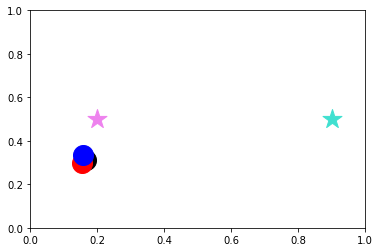

R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet


In [122]:
x = R1.betax
y = R1.betay
#plt.plot(x,y, 'o', c = 'black');
plt.scatter(x,y, s = 400, c = 'black')

x = R2.betax
y = R2.betay
plt.scatter(x, y, s = 400, c = 'red')

x = R3.betax
y = R3.betay
plt.scatter(x, y, s = 400, c = 'blue')

x = T.x
y = T.y
plt.scatter(x, y, s = 400, marker = '*', c = 'turquoise')

x = T2.x
y = T2.y
plt.scatter(x, y, s = 400, marker = '*', c = 'violet')

plt.axis([0, 1, 0, 1])
plt.show() 
print('R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet')

reach the most successful robot:

In [123]:
if (R1.delta > R2.delta) and (R1.delta > R2.delta): # now, brutally come close to the robot with the highest reward & fluctuate
    print("ciao")
    # change R2, R3 but not R1
    # R2
    R2.alphax = round(R1.alphax + np.random.uniform(0,0.1), 3) 
    R2.betax = round(1 - R2.alphax, 3)
    R2.alphay = round(R1.alphax + np.random.uniform(0,0.1), 3)
    R2.betay = round(1 - R2.alphax, 3)
    # R3
    R3.alphax = round(R1.alphax + np.random.uniform(0,0.1), 3)
    R3.betax = round(1 - R2.alphax, 3)
    R3.alphay = round(R1.alphax + np.random.uniform(0,0.1), 3)
    R3.betay = round(1 - R2.alphax, 3)
elif (R2.delta > R3.delta) and (R2.delta > R3.delta):
    print("glu glu")
    # change R1, R3 but not R2
    # R1
    R1.alphax = round(R2.alphax + np.random.uniform(0,0.1), 3)
    R1.betax = round(1 - R1.alphax, 3)
    R1.alphay = round(R2.alphay + np.random.uniform(0,0.1), 3)
    R1.betay = round(1 - R1.alphay, 3)
    # R3
    R3.alphax = round(R2.alphax + np.random.uniform(0,0.1), 3)
    R3.betax = round(1 - R2.alphax, 3)
    R3.alphay = round(R2.alphax + np.random.uniform(0,0.1), 3)
    R3.betay = round(1 - R2.alphax, 3)
elif (R3.delta > R1.delta) and (R3.delta > R2.delta):
    print("cri cri")
    # change R1, R2 but nor R3
    # R1
    R1.alphax = round(R3.alphax + np.random.uniform(0,0.1), 3)
    R1.betax = round(1 - R1.alphax, 3)
    R1.alphay = round(R3.alphay + np.random.uniform(0,0.1), 3)
    R1.betay = round(1 - R1.alphay, 3)
    # R2
    R2.alphax = round(R3.alphax + np.random.uniform(0,0.1), 3)
    R2.betax = round(1 - R2.alphax, 3)
    R2.alphay = round(R3.alphax + np.random.uniform(0,0.1), 3)
    R2.betay = round(1 - R2.alphax, 3)

ciao


plot and rewards

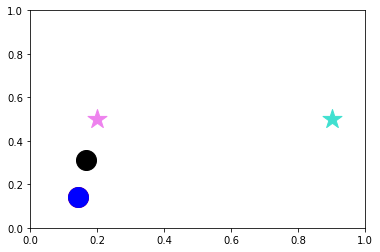

R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet
0.81
0.64
0.64


In [124]:
x = R1.betax
y = R1.betay
#plt.plot(x,y, 'o', c = 'black');
plt.scatter(x,y, s = 400, c = 'black')

x = R2.betax
y = R2.betay
plt.scatter(x, y, s = 400, c = 'red')

x = R3.betax
y = R3.betay
plt.scatter(x, y, s = 400, c = 'blue')

x = T.x
y = T.y
plt.scatter(x, y, s = 400, marker = '*', c = 'turquoise')

x = T2.x
y = T2.y
plt.scatter(x, y, s = 400, marker = '*', c = 'violet')

plt.axis([0, 1, 0, 1])
plt.show() 
print('R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet')


# new reward for $R_1$:
R1.delta = reward(T2,R1.betax,R1.betay)
R1.gamma = round((1 - R1.delta),3)
print(R1.delta)

# new reward for $R_2$:
R2.delta = reward(T2,R2.betax,R2.betay)
R2.gamma = round((1 - R2.delta),3)
print(R2.delta)

# new reward for $R_3$:
R3.delta = reward(T2,R3.betax,R3.betay)
R3.gamma = round((1 - R3.delta),3)
print(R3.delta)

check and move + rewards

In [125]:
if((R1.delta >= 0.8) or (R2.delta >= 0.8) or (R3.delta >= 0.8)):
    print('yuk')
    if (R1.delta > R2.delta and R1.delta > R3.delta):
        print('quokka')
        R2.betax = round(R1.betax + np.random.uniform(0,0.1), 3)
        R2.alphax = round(1 - R2.betax, 3)
        R2.betay = round(R1.betay + np.random.uniform(0,0.1), 3)
        R2.alphay = round(1 - R2.betay, 3)
        R3.betax = round(R1.betax + np.random.uniform(0,0.1), 3)
        R3.alphax = round(1 - R2.betax, 3)
        R3.betay = round(R1.betay + np.random.uniform(0,0.1), 3)
        R3.alphay = round(1 - R2.betay, 3)
    if (R2.delta > R1.delta and R2.delta > R3.delta):
        print('quagga')
        R1.betax = round(R2.betax + np.random.uniform(0,0.1), 3)
        R1.alphax = round(1 - R1.betax, 3)
        R1.betay = round(R2.betay + np.random.uniform(0,0.1), 3)
        R1.alphay = round(1 - R1.betay, 3)
        R3.betax = round(R2.betax + np.random.uniform(0,0.1), 3)
        R3.alphax = round(1 - R3.betax, 3)
        R3.betay = round(R2.betay + np.random.uniform(0,0.1), 3)
        R3.alphay = round(1 - R3.betay, 3)
    if (R3.delta > R1.delta and R3.delta > R2.delta):
        print('quark')
        R1.betax = round(R3.betax + np.random.uniform(0,0.1), 3)
        R1.alphax = round(1 - R1.betax, 3)
        R1.betay = round(R3.betay + np.random.uniform(0,0.1), 3)
        R1.alphay = round(1 - R1.betay, 3)
        R2.betax = round(R3.betax + np.random.uniform(0,0.1), 3)
        R2.alphax = round(1 - R2.betax, 3)
        R2.betay = round(R3.betay + np.random.uniform(0,0.1), 3)
        R2.alphay = round(1 - R2.betay, 3)
        
R1.delta = reward(T2, R1.betax, R1.betay)
print(R2.delta)

R2.delta = reward(T2, R2.betax, R2.betay)
print(R2.delta)

R3.delta = reward(T2, R3.betax, R3.betay)
print(R3.delta)

yuk
quokka
0.64
0.84
0.9


plot

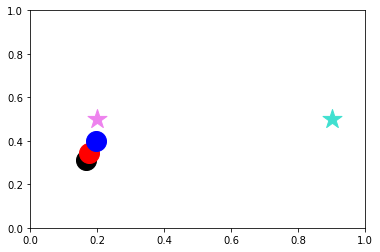

R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet


In [126]:
x = R1.betax
y = R1.betay
#plt.plot(x,y, 'o', c = 'black');
plt.scatter(x,y, s = 400, c = 'black')

x = R2.betax
y = R2.betay
plt.scatter(x, y, s = 400, c = 'red')

x = R3.betax
y = R3.betay
plt.scatter(x, y, s = 400, c = 'blue')

x = T.x
y = T.y
plt.scatter(x, y, s = 400, marker = '*', c = 'turquoise')

x = T2.x
y = T2.y
plt.scatter(x, y, s = 400, marker = '*', c = 'violet')

plt.axis([0, 1, 0, 1])
plt.show() 
print('R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet')

GHZ

In [127]:
# a new circuit
q = QuantumRegister(9, 'q'); # qubits
#c0 = ClassicalRegister(6, 'c0');
c0 = ClassicalRegister(1, 'c0');
c1 = ClassicalRegister(1, 'c1');
c3 = ClassicalRegister(1, 'c3');
c4 = ClassicalRegister(1, 'c4');
c6 = ClassicalRegister(1, 'c6');
c7 = ClassicalRegister(1, 'c7');
qc_small = QuantumCircuit(q, c0, c1, c3, c4, c6, c7);

In [128]:


if ((R3.delta - R2.delta) <= 0.3) and ((R3.delta - R1.delta) <= 0.3) and ((R2.delta - R1.delta) <= 0.3):
    # 0.3 rather than 0.1
    print("cometa")# GHZ for all
    qc_small.h(q[0]) # Hadamard
    qc_small.cx(q[0], q[1]) # CNOT
    qc_small.cx(q[0], q[2]) # CNOT
    qc_small.cx(q[0], q[3]) # CNOT
    qc_small.cx(q[0], q[4]) # CNOT
    qc_small.cx(q[0], q[5]) # CNOT
    qc_small.cx(q[0], q[6]) # CNOT
    qc_small.cx(q[0], q[7]) # CNOT
    # barrier
    qc_small.barrier(q[0], q[1], q[2], q[3], q[4], q[5], q[6], q[7])
    # measures
    qc_small.measure(q[0],c0[0])
    qc_small.measure(q[3],c3[0])
    qc_small.measure(q[6],c6[0])
    qc_small.measure(q[1],c1[0])
    qc_small.measure(q[4],c4[0])
    qc_small.measure(q[7],c7[0])
    # draw circuit
    draw_circuit(qc_small)
    # definition of quantum simulator
    simulator = Aer.get_backend('qasm_simulator') # statevector_simulator # aer_simulator # qasm_simulator
    qc_small = transpile(qc_small, simulator)
    # Run and get counts
    result = simulator.run(qc_small, shots=1024).result()
    counts_GHZ_all = result.get_counts(qc_small)
    counts_GHZ = counts_GHZ_all.most_frequent() # does not work if multiple states have the same counts
    # decide something if multiple states have the same count --> e.g., ``choose the first''
    print(counts_GHZ_all)
    print(counts_GHZ)
    #plot_histogram(counts_GHZ_all, title='outcomes')
    #plot_histogram(counts_GHZ, title='outcomes')

print(counts_GHZ) # order: R3, R2, R1. Add some uncertainty?
# export as an array
str_ = counts_GHZ
arr_GHZ = str_.split(' ') # to split the string and avoid empty spaces as array elements
print(arr_GHZ)
# We do not need to update rewards; they should be done externally... excluded str[0], str[3], str[6]

cometa


CircuitComposer(circuit=<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fb3a84eb0a0>, editable=Fals…

{'1 1 1 1 1 1': 488, '0 0 0 0 0 0': 536}
0 0 0 0 0 0
0 0 0 0 0 0
['0', '0', '0', '0', '0', '0']


In [129]:
# define the new 0:


if (R1.delta >= R2.delta) and (R1.delta >= R3.delta):
    print('gosh')
    new_zero_betax = R1.betax + np.random.uniform(0,0.1)
    new_zero_alphax = 1 - R1.betax
    new_zero_betay = R1.betay + np.random.uniform(0,0.1)
    new_zero_alphay = 1 - R2.betay + np.random.uniform(0,0.1)

if (R2.delta >= R1.delta) and (R2.delta >= R3.delta):
    print('kinda')
    new_zero_betax = R2.betax + np.random.uniform(0,0.1)
    new_zero_alphax = 1 - R2.betax
    new_zero_betay = R2.betay + np.random.uniform(0,0.1)
    new_zero_alphay = 1 - R2.betay

if (R3.delta >= R2.delta) and (R3.delta >= R1.delta):
    print('uffdah')
    new_zero_betax = R3.betax + np.random.uniform(0,0.1)
    new_zero_alphax = 1 - R3.betax
    new_zero_betay = R3.betay + np.random.uniform(0,0.1)
    new_zero_alphay = 1 - R3.betay

uffdah


In [130]:
# define the new 1:


# flip thanks to the 'minus' sign?
# I had tried with if(R1... < R2...) etc., but it is not ok,
# because we need to initialize all elements.

if (R1.delta >= R2.delta) and (R1.delta >= R3.delta):
    print('gosh')
    new_one_betax = R1.betax - np.random.uniform(0,0.1)
    new_one_alphax = 1 - R1.betax
    new_one_betay = R1.betay - np.random.uniform(0,0.1)
    new_one_alphay = 1 - R2.betay

if (R2.delta >= R1.delta) and (R2.delta >= R3.delta):
    print('kinda')
    new_one_betax = R2.betax - np.random.uniform(0,0.1)
    new_one_alphax = 1 - R2.betax
    new_one_betay = R2.betay - np.random.uniform(0,0.1)
    new_one_alphay = 1 - R2.betay

if (R3.delta >= R2.delta) and (R3.delta >= R1.delta):
    print('uffdah')
    new_one_betax = R3.betax - np.random.uniform(0,0.1)
    new_one_alphax = 1 - R3.betax
    new_one_betay = R3.betay - np.random.uniform(0,0.1)
    new_one_alphay = 1 - R3.betay

uffdah


In [131]:
# choose the new 0 or new 1 according to the outcome of GHZ:

if (arr_GHZ[0] =='0'):
    R1.alphax = new_zero_alphax
    R1.betax = new_zero_betax
if (arr_GHZ[1] =='0'):
    R1.alphay = new_zero_alphay
    R1.betay = new_zero_betay
if (arr_GHZ[2] =='0'):
    R2.alphax = new_zero_alphax
    R2.betax = new_zero_betax
if (arr_GHZ[3] =='0'):
    R2.alphay = new_zero_alphay
    R2.betay = new_zero_betay
if (arr_GHZ[3] =='0'):
    R2.alphax = new_zero_alphax
    R2.betax = new_zero_betax
if (arr_GHZ[4] =='0'):
    R3.alphax = new_zero_alphax
    R3.betax = new_zero_betax
if (arr_GHZ[5] =='0'):
    R3.alphay = new_zero_alphay
    R3.betay = new_zero_betay
if (arr_GHZ[0] =='1'):
    R1.alphax = new_one_alphax
    R1.betax = new_one_betax
if (arr_GHZ[1] =='1'):
    R1.alphay = new_one_alphay
    R1.betay = new_one_betay
if (arr_GHZ[2] =='1'):
    R2.alphax = new_one_alphax
    R2.betax = new_one_betax
if (arr_GHZ[3] =='1'):
    R2.alphay = new_one_alphay
    R2.betay = new_one_betay
if (arr_GHZ[3] =='1'):
    R2.alphax = new_one_alphax
    R2.betax = new_one_betax
if (arr_GHZ[4] =='1'):
    R3.alphax = new_one_alphax
    R3.betax = new_one_betax
if (arr_GHZ[5] =='1'):
    R3.alphay = new_one_alphay
    R3.betay = new_one_betay


# new rewards:

R1.delta = reward(T2, R1.betax, R2.betay)
R2.delta = reward(T2, R2.betax, R3.betay)
R3.delta = reward(T2, R2.betax, R3.betay)
print(R1.delta, R2.delta, R3.delta)

1.0 1.0 1.0


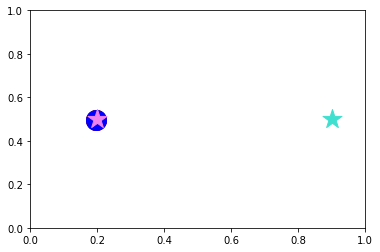

R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet


In [132]:
x = R1.betax
y = R1.betay
#plt.plot(x,y, 'o', c = 'black');
plt.scatter(x,y, s = 400, c = 'black')

x = R2.betax
y = R2.betay
plt.scatter(x, y, s = 400, c = 'red')

x = R3.betax
y = R3.betay
plt.scatter(x, y, s = 400, c = 'blue')

x = T.x
y = T.y
plt.scatter(x, y, s = 400, marker = '*', c = 'turquoise')

x = T2.x
y = T2.y
plt.scatter(x, y, s = 400, marker = '*', c = 'violet')

plt.axis([0, 1, 0, 1])
plt.show() 
print('R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet')

In [133]:
if((R1.delta >= 0.8) or (R2.delta >= 0.8) or (R3.delta >= 0.8)):
    print('yuk')
    if (R1.delta > R2.delta and R1.delta > R3.delta):
        print('quokka')
        R2.betax = round(R1.betax + np.random.uniform(0,0.1), 3)
        R2.alphax = round(1 - R2.betax, 3)
        R2.betay = round(R1.betay + np.random.uniform(0,0.1), 3)
        R2.alphay = round(1 - R2.betay, 3)
        R3.betax = round(R1.betax + np.random.uniform(0,0.1), 3)
        R3.alphax = round(1 - R2.betax, 3)
        R3.betay = round(R1.betay + np.random.uniform(0,0.1), 3)
        R3.alphay = round(1 - R2.betay, 3)
    if (R2.delta > R1.delta and R2.delta > R3.delta):
        print('quagga')
        R1.betax = round(R2.betax + np.random.uniform(0,0.1), 3)
        R1.alphax = round(1 - R1.betax, 3)
        R1.betay = round(R2.betay + np.random.uniform(0,0.1), 3)
        R1.alphay = round(1 - R1.betay, 3)
        R3.betax = round(R2.betax + np.random.uniform(0,0.1), 3)
        R3.alphax = round(1 - R3.betax, 3)
        R3.betay = round(R2.betay + np.random.uniform(0,0.1), 3)
        R3.alphay = round(1 - R3.betay, 3)
    if (R3.delta > R1.delta and R3.delta > R2.delta):
        print('quark')
        R1.betax = round(R3.betax + np.random.uniform(0,0.1), 3)
        R1.alphax = round(1 - R1.betax, 3)
        R1.betay = round(R3.betay + np.random.uniform(0,0.1), 3)
        R1.alphay = round(1 - R1.betay, 3)
        R2.betax = round(R3.betax + np.random.uniform(0,0.1), 3)
        R2.alphax = round(1 - R2.betax, 3)
        R2.betay = round(R3.betay + np.random.uniform(0,0.1), 3)
        R2.alphay = round(1 - R2.betay, 3)
        
R1.delta = reward(T2, R1.betax, R1.betay)
print(R2.delta)

R2.delta = reward(T2, R2.betax, R2.betay)
print(R2.delta)

R3.delta = reward(T2, R3.betax, R3.betay)
print(R2.delta)

yuk
1.0
1.0
1.0


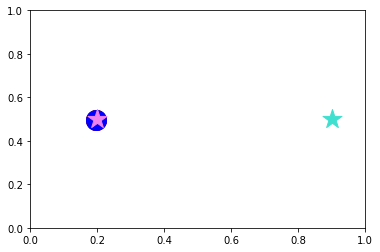

R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet


(1.0, 1.0, 1.0)

In [134]:
x = R1.betax
y = R1.betay
#plt.plot(x,y, 'o', c = 'black');
plt.scatter(x,y, s = 400, c = 'black')

x = R2.betax
y = R2.betay
plt.scatter(x, y, s = 400, c = 'red')

x = R3.betax
y = R3.betay
plt.scatter(x, y, s = 400, c = 'blue')

x = T.x
y = T.y
plt.scatter(x, y, s = 400, marker = '*', c = 'turquoise')

x = T2.x
y = T2.y
plt.scatter(x, y, s = 400, marker = '*', c = 'violet')

plt.axis([0, 1, 0, 1])
plt.show() 
print('R_1 is black, R_2 is red, and R_3 is blue, Target 1 is turquoise, Target 2 is violet')


R1.delta, R2.delta, R3.delta